In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import pandas_datareader.data as web
import yfinance as yf
import datetime
import dateutil.parser

from datetime import date, datetime
from pmdarima.arima import auto_arima
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import (
    mean_absolute_percentage_error,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score
)
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [ ]:
aapl = yf.Ticker("SPY")

### Plot an initial time series

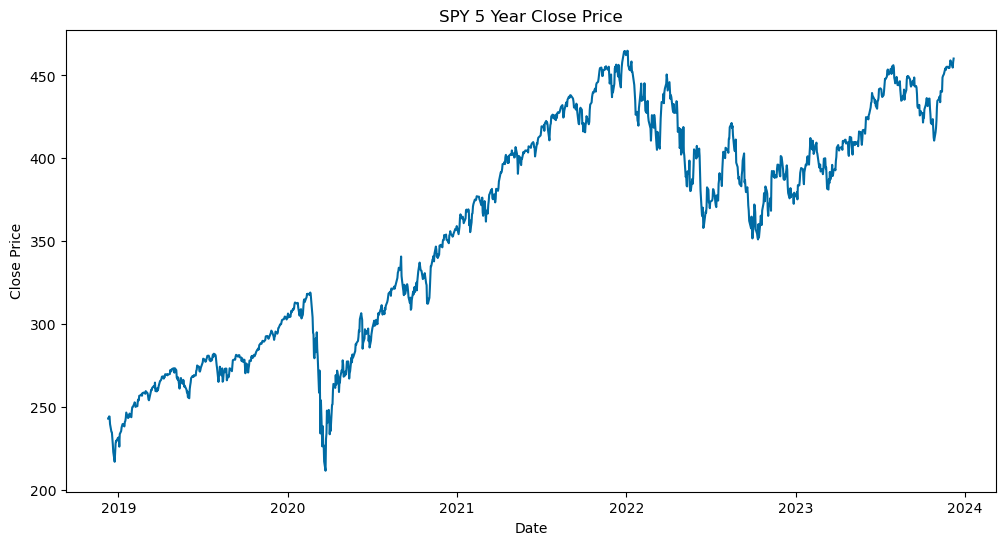

In [ ]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

In [ ]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=303.794836, mean2=416.147950, mean_percent_diff=36.983221
variance1=2195.884499, variance2=709.054652, var_percent_diff=-67.709838


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [ ]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.591253
p-value: 0.487986
Critical Values:
{'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [ ]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.692335042527655, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.69
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

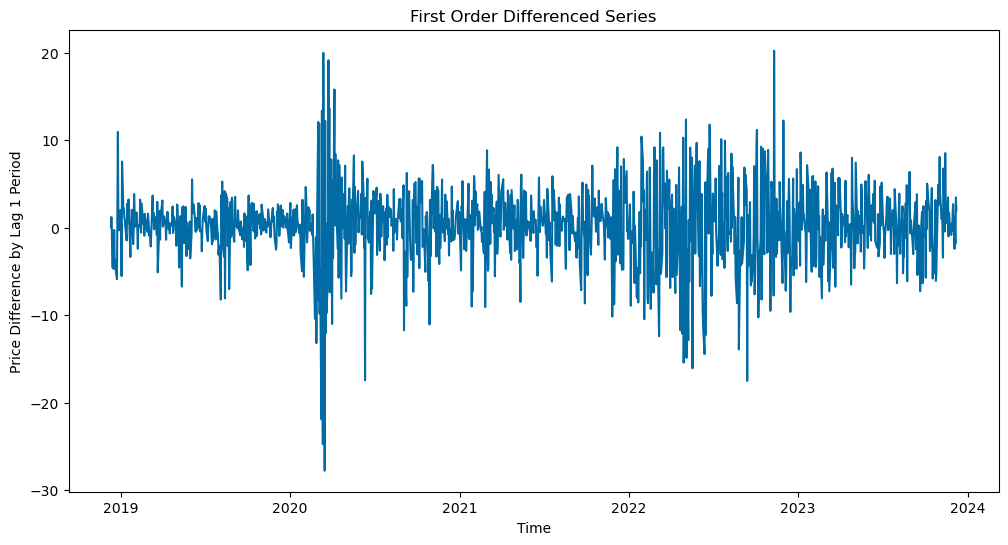

In [ ]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14)
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [ ]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -11.054566
p-value: 0.000000
Critical Values:
{'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

## Smoothing Methods
##### Reference
Brownlee, J. (2020, April 12). A gentle introduction to exponential smoothing for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use this because we assume that these time series will have level, trends, seasonality, and noise
Brownlee, J. (2020, August 28). How to grid search triple exponential smoothing for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [ ]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

### Time Series Prediction
#### Data partition
##### 2 years train; last 1 year validation

In [ ]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [ ]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

### Simple Exponential forecaster
#### Plot an initial time series
##### Reference: ADS506 - Module 1 and https://www.statsmodels.org/stable/tsa.html

In [ ]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
print('AIC = %s' %(ses_model.aic))
print('BIC = %s' %(ses_model.bic))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

AIC = 3054.459128596632
BIC = 3064.2885903820693
Time Series Evaluation Metrics
MSE = 1633.363253696658
MAE = 34.072759767790885
RMSE = 40.41488901007472
MAPE = 0.07850921581532792
r2 = -1.946390595852527



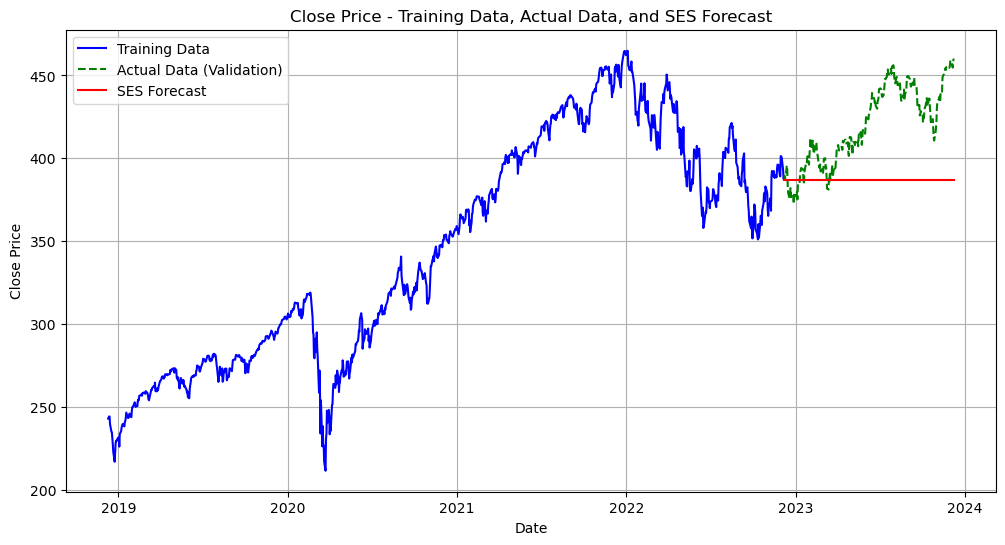

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

Simple Exponential Smoothing RMSE is 34.56% and it is higher to our success rate criteria. The forecast also doesn't include trend, seasonality and noise

In [ ]:
# #impute to decompose
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

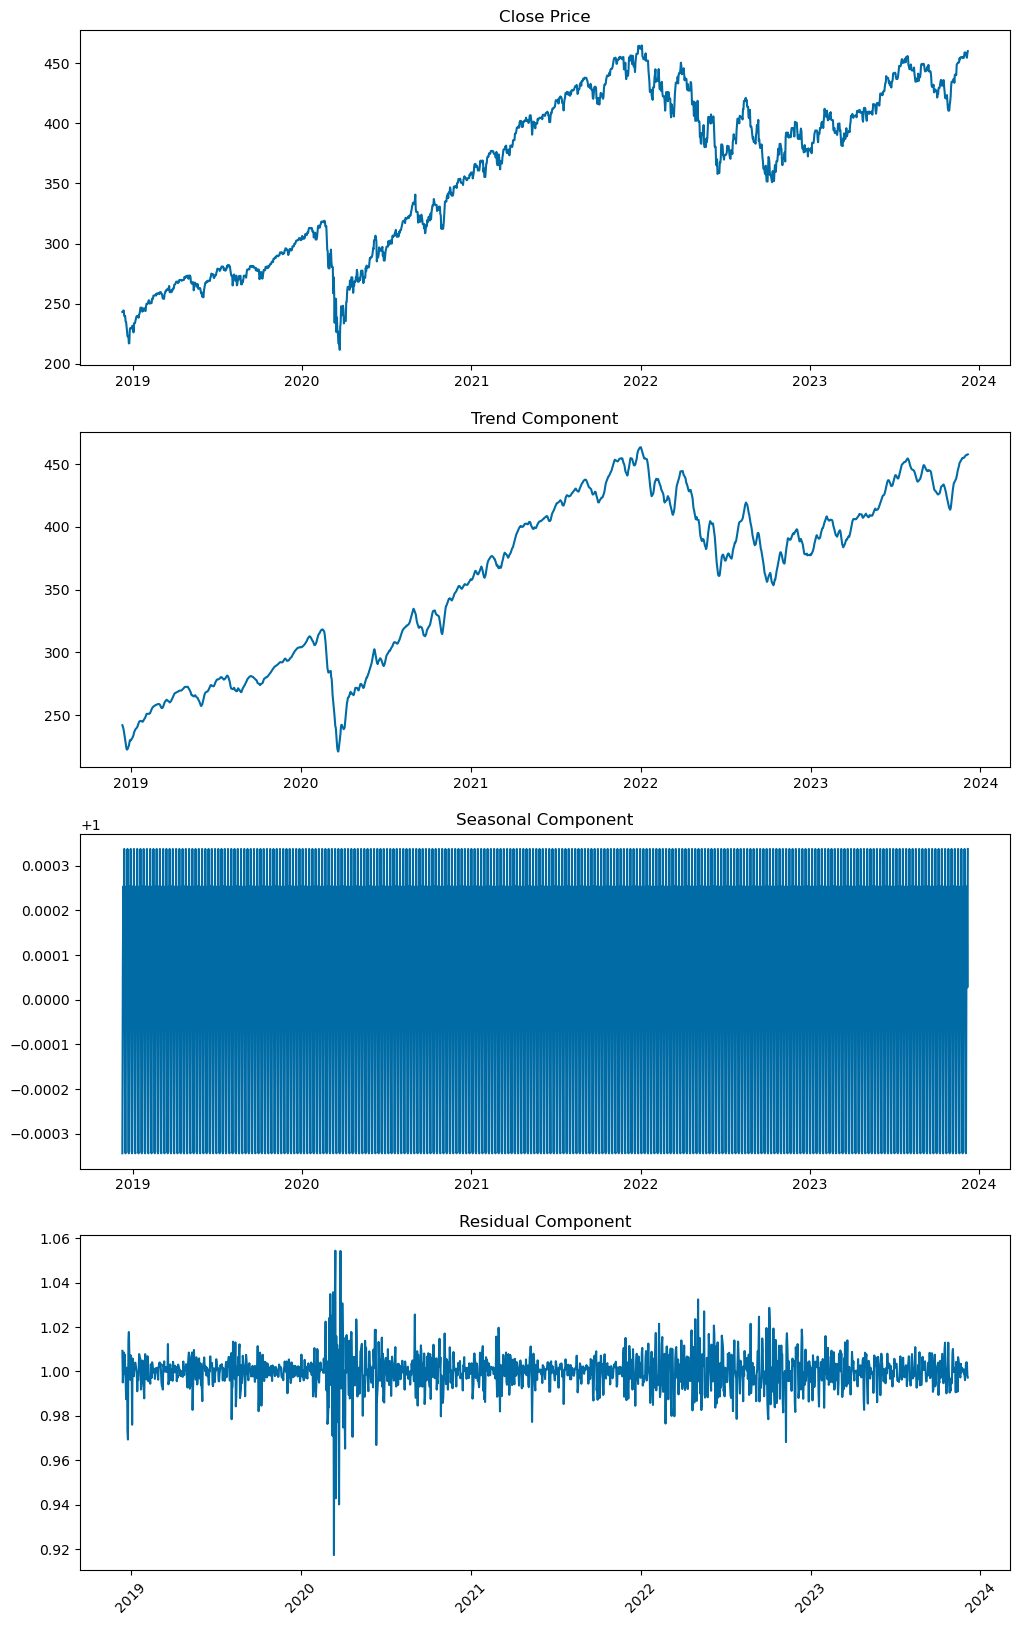

In [ ]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

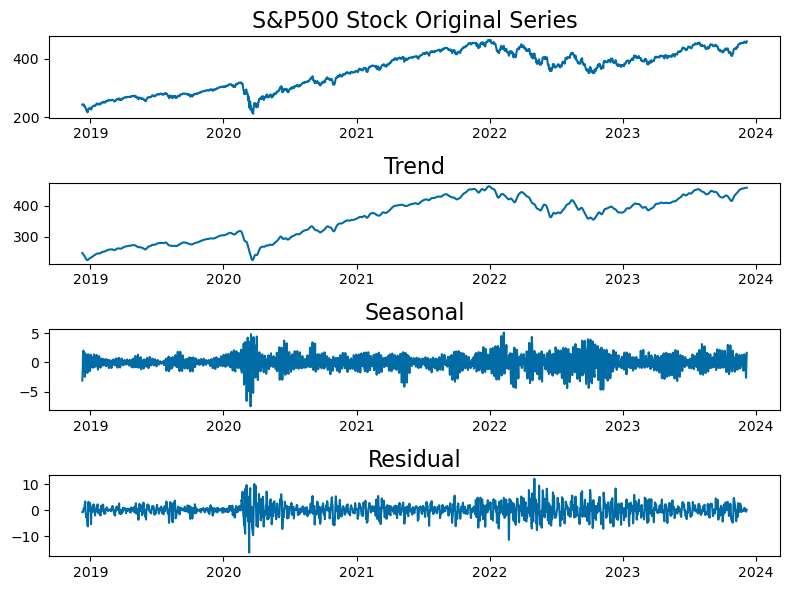

In [ ]:
stl_close = STL(close)
stl_close_f = stl_close.fit()


# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(close)
plt.title('S&P500 Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(stl_close_f.trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(stl_close_f.seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(stl_close_f.resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

Seasonal-Trend decomposition using LOESS (STL) shows a positive trend on SPY and seasonal around quarterly basis

### Anomaly Detection from STL Decomposition

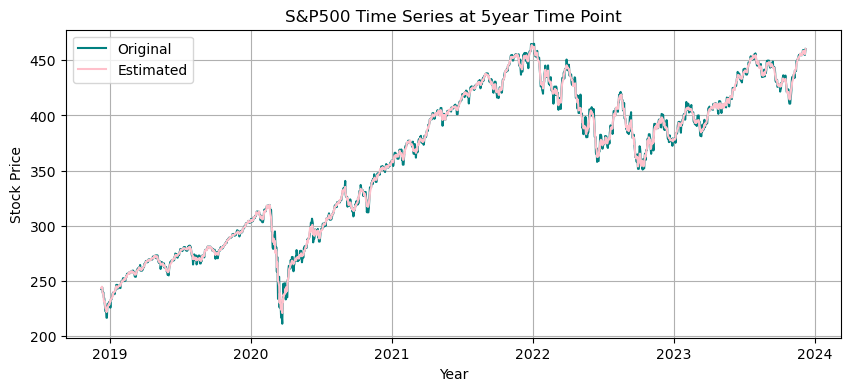

In [ ]:
estimated0 = stl_close_f.trend + stl_close_f.seasonal
plt.figure(figsize=(10,4))
plt.plot(close, label='Original', color = 'teal')
plt.plot(estimated0, label ='Estimated', color = 'pink')


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('S&P500 Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Taking residuals and detecting anomaly at 3std. dev:

resid_mu0 = stl_close_f.resid.mean()
resid_dev0 = stl_close_f.resid.std()

lower0 = resid_mu0 - 3*resid_dev0
upper0 = resid_mu0 + 3*resid_dev0

Text(0.5, 1.0, 'S&P500 at 5year Time Point')

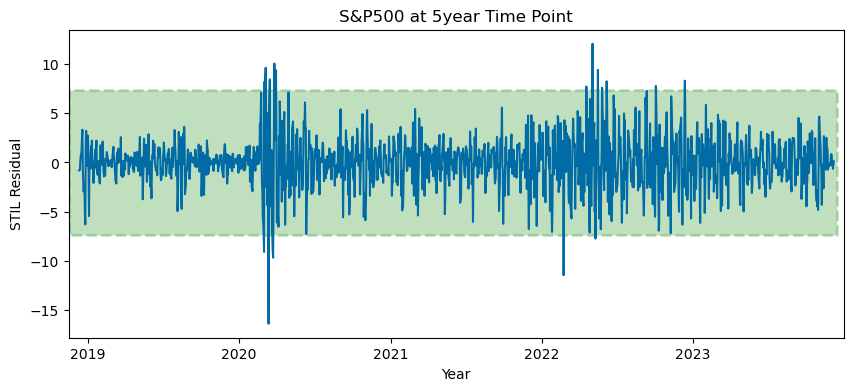

In [ ]:
# Plot residual threshold:

plt.figure(figsize=(10,4))
plt.plot(stl_close_f.resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower0, upper0, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,11,15), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('S&P500 at 5year Time Point')

In [ ]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies0 = close[(stl_close_f.resid < lower0) | (stl_close_f.resid > upper0)]
anomalies0 = pd.DataFrame(anomalies0)

Text(0.5, 1.0, 'S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

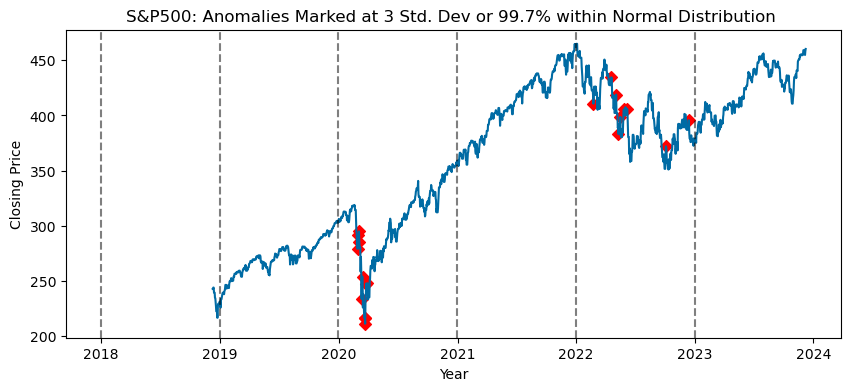

In [ ]:
# Plot identified residual anomalies:

plt.figure(figsize=(10,4))
plt.plot(close)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies0.index, anomalies0.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

In [ ]:
# Anomalies identified outside 3std dev of residuals:

anomalies0.head()

Close
Date                                 
2020-03-01 00:00:00-05:00  279.321075
2020-03-02 00:00:00-05:00  291.417542
2020-03-04 00:00:00-05:00  294.971893
2020-03-05 00:00:00-05:00  285.166595
2020-03-12 00:00:00-04:00  233.924118

### Gather parameters from decomposition

In [ ]:
stl_close.config, stl_close.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

### Autocorrelation - Raw Values
Reference: https://www.statsmodels.org/devel/graphics.html#time-series-plots

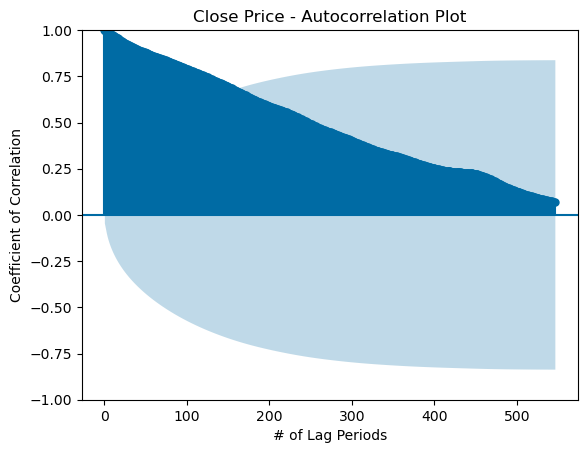

In [ ]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

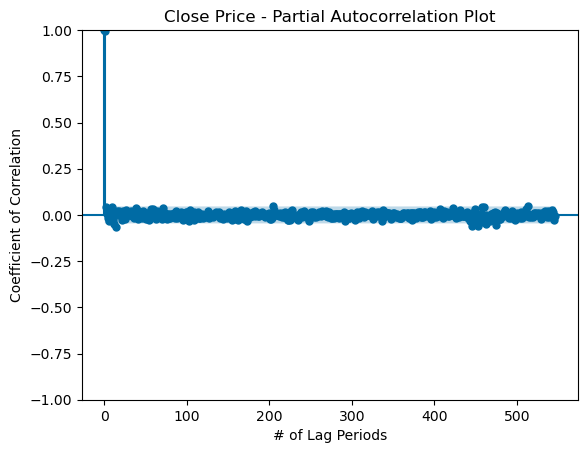

In [ ]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

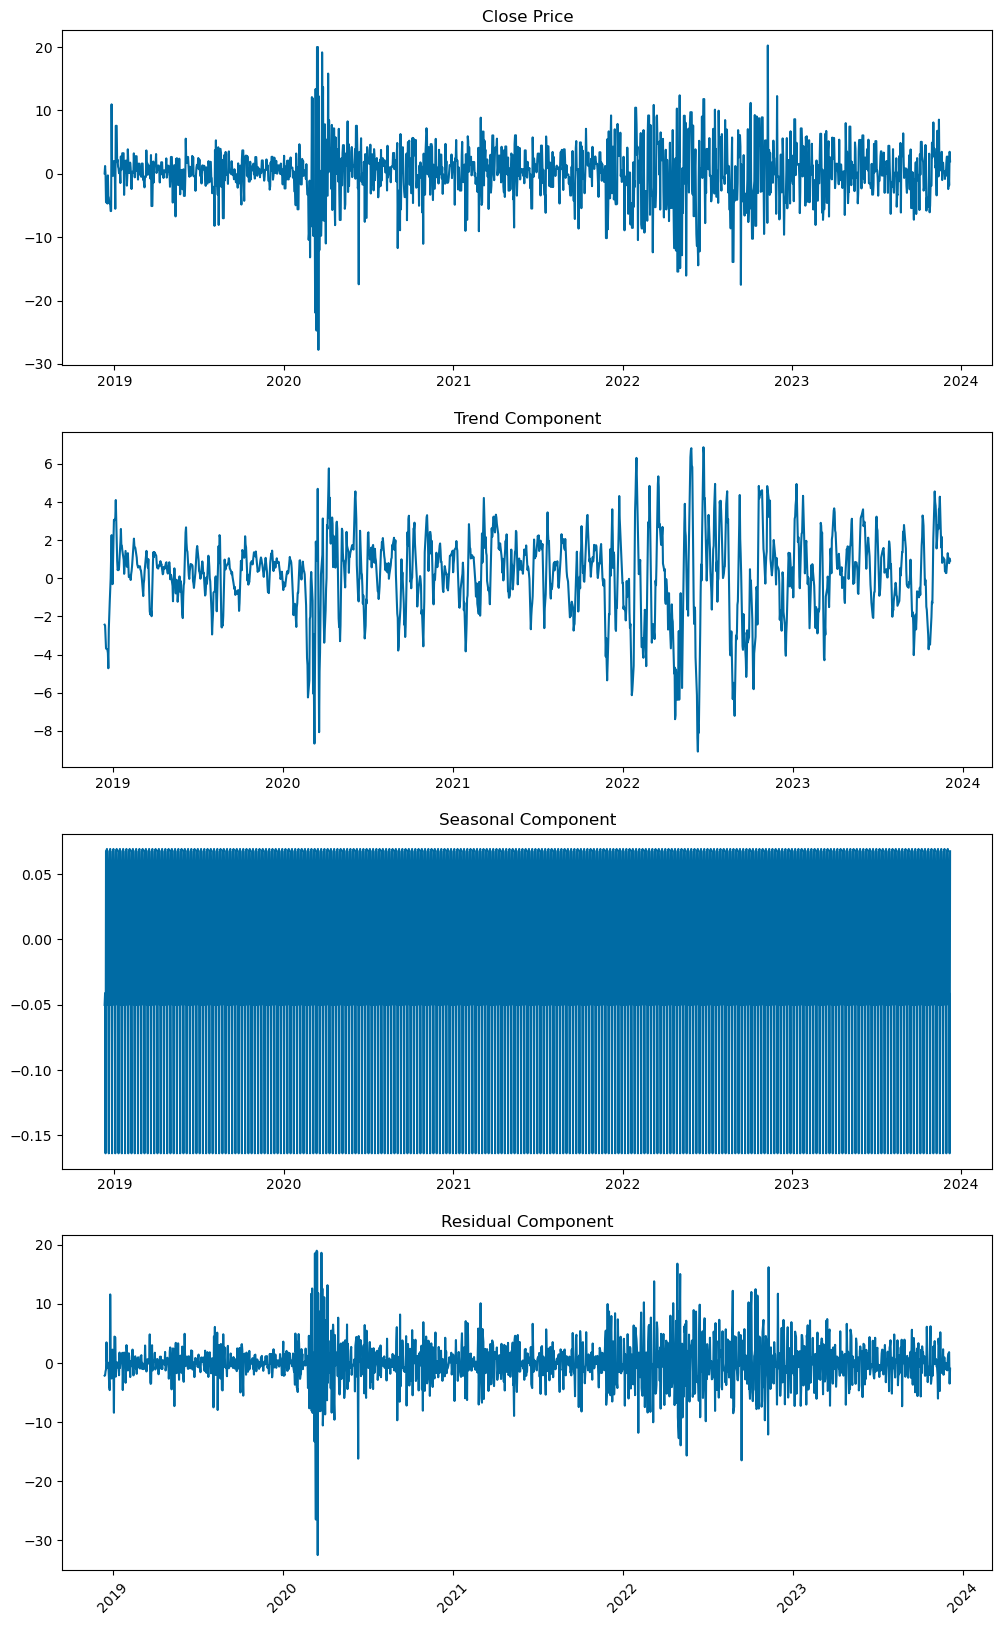

In [ ]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

### Decompose using STL

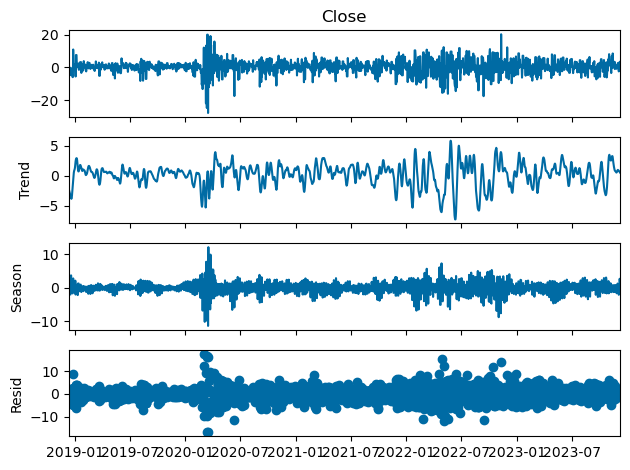

In [ ]:
stl = STL(ts_lag_1)
stl_plot = stl.fit().plot()

In [ ]:
stl.config, stl.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

## ARIMA Parameter Selection
Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29 and

### ACF on lag_1 period

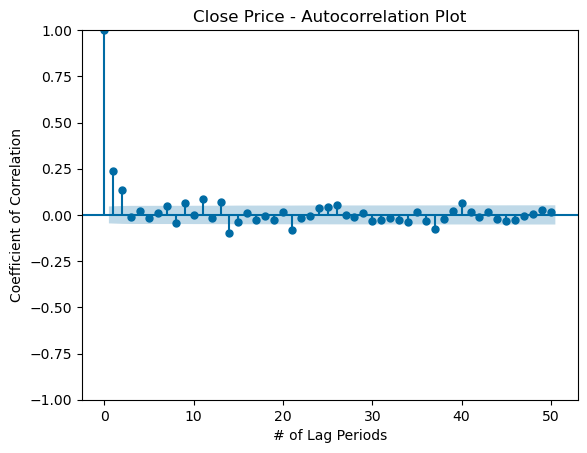

In [ ]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we see a positive pattern in the quarterly basis. We may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

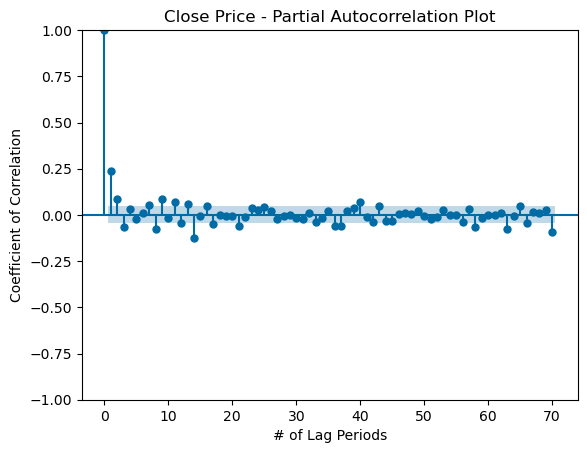

In [ ]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

### Iterate through different AR and MA orders to find best AIC and BIC model
Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. https://www.youtube.com/watch?v=McEN54l3EPU
#### Finding AR_orders code would take a small of time

In [ ]:
ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')


AIC for AR(1): 10436.219511431289
BIC for AR(1): 10452.744227755325


AIC for AR(2): 10424.508542506526
BIC for AR(2): 10446.541497605242


AIC for AR(3): 10418.692978237334
BIC for AR(3): 10446.234172110728


AIC for AR(8): 10410.102789351982
BIC for AR(8): 10465.185177098769


AIC for AR(9): 10398.550314145255
BIC for AR(9): 10459.14094066672


AIC for AR(11): 10393.572577228742
BIC for AR(11): 10465.179681299565


AIC for AR(14): 10362.217425868741
BIC for AR(14): 10450.3492462636


AIC for AR(21): 10361.355963473226
BIC for AR(21): 10488.045455290836




### The lower AIC and BIC is the better model selection; AR(14) has the lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

#### Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube].
#### https://www.youtube.com/watch?v=McEN54l3EPU
#### Finding AR_orders code (q) would take some time

In [ ]:
#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')


AIC for MA(0): 10469.239088156988
BIC for MA(0): 10551.862669777169


AIC for MA(1): 10362.217425868741
BIC for MA(1): 10450.3492462636


AIC for MA(2): 10364.249039464154
BIC for MA(2): 10457.88909863369


AIC for MA(11): 10355.08067646741
BIC for MA(11): 10498.294884609057


AIC for MA(13): 10350.053919770544
BIC for MA(13): 10504.284605461546


AIC for MA(14): 10354.898778703604
BIC for MA(14): 10514.637703169285


AIC for MA(21): 10359.15555247834
BIC for MA(21): 10557.452148366772


AIC for MA(37): 10346.261379074931
BIC for MA(37): 10632.689795358221


AIC for MA(40): 10349.963893915232
BIC for MA(40): 10652.917026522558




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [ ]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA
print('AIC = %s' %(arima_model.aic))
print('BIC = %s' %(arima_model.bic))
arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

AIC = 10362.217425868741
BIC = 10450.3492462636
Time Series Evaluation Metrics
MSE = 176789.9221451403
MAE = 419.80392871660104
RMSE = 420.46393679498874
MAPE = 0.9994505327095261
r2 = -317.9077278866468



### Result: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

### Find optimal AES model parameters

In [ ]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [ ]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3560.1369475377305
BIC = 3594.5400637867606
Time Series Evaluation Metrics
MSE = 1494.004974458805
MAE = 32.36335716687344
RMSE = 38.652360528935425
MAPE = 0.07455317194206454
r2 = -1.6950050436972952

Results for Seasonal Period 3
AIC = 3867.795809542727
BIC = 3907.1136566844757
Time Series Evaluation Metrics
MSE = 1332.0988535975223
MAE = 30.27615990348647
RMSE = 36.497929442607045
MAPE = 0.06973382975049566
r2 = -1.4029459007987373

Results for Seasonal Period 8
AIC = 4443.356290752686
BIC = 4507.247792358027
Time Series Evaluation Metrics
MSE = 426.6565841591002
MAE = 17.27977116339409
RMSE = 20.655667119681713
MAPE = 0.04236173248968343
r2 = 0.230362906487672

Results for Seasonal Period 9
AIC = 4324.880035565551
BIC = 4393.686268063611
Time Series Evaluation Metrics
MSE = 1112.4034568016489
MAE = 27.43438146554094
RMSE = 33.35271288518595
MAPE = 0.0632538073642865
r2 = -1.0066418639554628

Results for Seasonal Period 11
AIC = 4538.642236758211


### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [ ]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3922.6164600644047
BIC = 3957.0195763134348
Time Series Evaluation Metrics
MSE = 177.60396325994682
MAE = 10.876726002674042
RMSE = 13.326813694951499
MAPE = 0.025957576687906905
r2 = 0.6796238399811407

Results for Seasonal mul
AIC = 3923.9456429701822
BIC = 3958.3487592192123
Time Series Evaluation Metrics
MSE = 181.93415165082266
MAE = 10.927860173795521
RMSE = 13.488296840254616
MAPE = 0.026207828598420448
r2 = 0.6718127016294781

Results for Seasonal additive
AIC = 3922.6164600644047
BIC = 3957.0195763134348
Time Series Evaluation Metrics
MSE = 177.60396325994682
MAE = 10.876726002674042
RMSE = 13.326813694951499
MAPE = 0.025957576687906905
r2 = 0.6796238399811407

Results for Seasonal multiplicative
AIC = 3923.9456429701822
BIC = 3958.3487592192123
Time Series Evaluation Metrics
MSE = 181.93415165082266
MAE = 10.927860173795521
RMSE = 13.488296840254616
MAPE = 0.026207828598420448
r2 = 0.6718127016294781

Results for Seasonal None
AIC = 4670.4085840

### Validation statistics suggest additive seasonality is optimal where it has the lowest RMSE

### Searching for ideal trend parameter

In [ ]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train,
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     #damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Trend add
AIC = 3931.771935920872
BIC = 3966.175052169902
Time Series Evaluation Metrics
MSE = 219.66089026982036
MAE = 12.016618910379064
RMSE = 14.820961179013336
MAPE = 0.028277688615378417
r2 = 0.6037582087739379

Results for Trend mul
AIC = 3922.6171893804817
BIC = 3957.0203056295118
Time Series Evaluation Metrics
MSE = 177.60383885526392
MAE = 10.876722961705427
RMSE = 13.326809027492812
MAPE = 0.025957571587054244
r2 = 0.679624064392206

Results for Trend additive
AIC = 3931.771935920872
BIC = 3966.175052169902
Time Series Evaluation Metrics
MSE = 219.66089026982036
MAE = 12.016618910379064
RMSE = 14.820961179013336
MAPE = 0.028277688615378417
r2 = 0.6037582087739379

Results for Trend multiplicative
AIC = 3922.6171893804817
BIC = 3957.0203056295118
Time Series Evaluation Metrics
MSE = 177.60383885526392
MAE = 10.876722961705427
RMSE = 13.326809027492812
MAPE = 0.025957571587054244
r2 = 0.679624064392206

Results for Trend None
AIC = 3886.8266397165085
BIC = 3911.400

### Validation statistics suggest multiplicative trend is optimal. Upon further investigation, the trend parameter varies on which value is optimal as new data is rolled into the dataframe. Further exploration is needed to determine which trend parameter value is optimal for the greatest likelihood on a rolling 3-day basis.

### Searching for ideal aes_param_damped_trend parameter

In [ ]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3910.0979973800113
BIC = 3949.41584452176
Time Series Evaluation Metrics
MSE = 635.8740165790123
MAE = 20.252289759597687
RMSE = 25.216542518335306
MAPE = 0.04676796041305556
r2 = -0.14704014453316527

Results for Damped Trend False
AIC = 3922.616570092393
BIC = 3957.019686341423
Time Series Evaluation Metrics
MSE = 177.60406486319104
MAE = 10.876730317352251
RMSE = 13.32681750693657
MAPE = 0.025957585616772742
r2 = 0.6796236567011248



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [ ]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3913.5609650568285
BIC = 3947.9640813058586
Time Series Evaluation Metrics
MSE = 208.38876688783483
MAE = 11.761399890355769
RMSE = 14.43567687667727
MAPE = 0.027737330438992912
r2 = 0.6240917617988424

Results for Initialization Method estimated
AIC = 3908.348063412961
BIC = 3942.751179661991
Time Series Evaluation Metrics
MSE = 206.22029406411653
MAE = 11.712456932478515
RMSE = 14.360372351165429
MAPE = 0.027635014549691823
r2 = 0.628003425613187

Results for Initialization Method heuristic
AIC = 3931.7711439552945
BIC = 3966.1742602043246
Time Series Evaluation Metrics
MSE = 219.66129054043367
MAE = 12.016628751935023
RMSE = 14.820974682538044
MAPE = 0.028277709941977404
r2 = 0.6037574867339581

Results for Initialization Method legacy-heuristic
AIC = 3913.5609650568285
BIC = 3947.9640813058586
Time Series Evaluation Metrics
MSE = 208.38876688783483
MAE = 11.761399890355769
RMSE = 14.43567687667727
MAPE = 0.027737330438992912
r2 = 0.62409

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [ ]:
aes_model = ExponentialSmoothing(close_train,
                                 trend= 'mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3,
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1,
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3910.0978116514298
BIC = 3949.4156587931784
Time Series Evaluation Metrics
MSE = 635.8739712760527
MAE = 20.252288914397276
RMSE = 25.216541620056717
MAPE = 0.04676795798145056
r2 = -0.14704006281208226

None


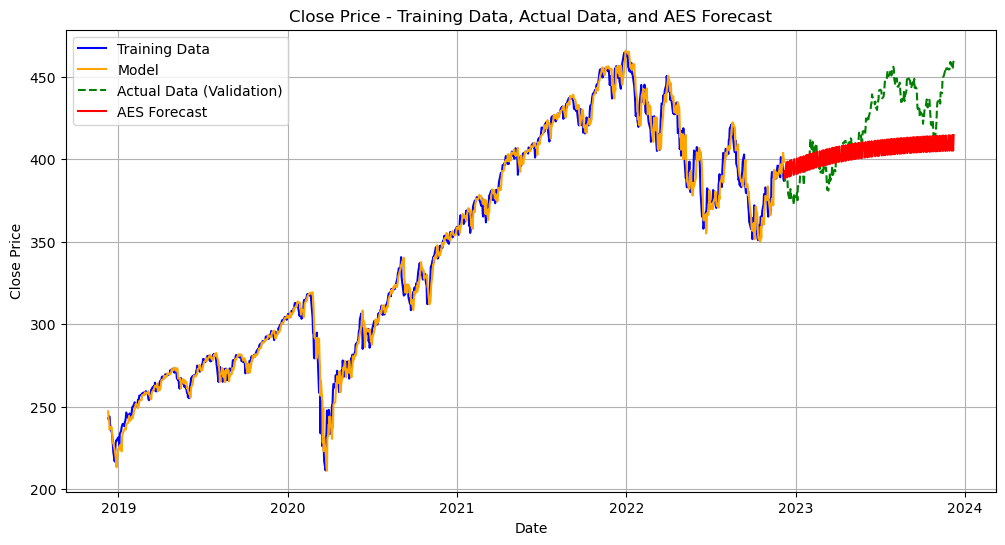

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [ ]:
aes_model = ExponentialSmoothing(close_train,
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2,
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1,
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3588.947331987173
BIC = 3623.350448236203
Time Series Evaluation Metrics
MSE = 986.3086662651427
MAE = 25.858804411066366
RMSE = 31.405551519837104
MAPE = 0.05953684137243272
r2 = -0.7791820480315312

None


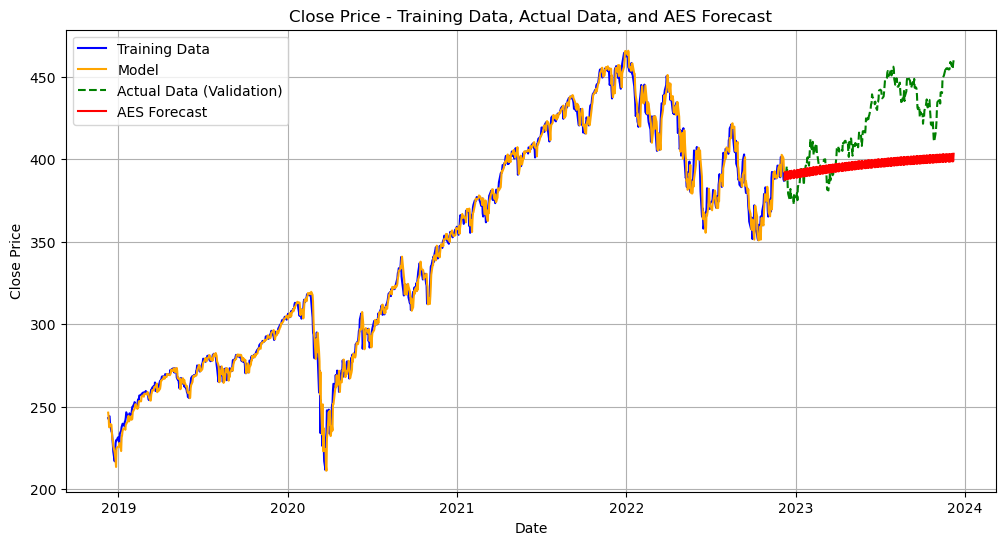

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

#####  https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [ ]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,1)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                ARIMA(14, 1, 1)   Log Likelihood               -2945.890
Date:                Sun, 10 Dec 2023   AIC                           5923.781
Time:                        15:37:57   BIC                           6008.338
Sample:                    12-10-2018   HQIC                          5955.326
                         - 12-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0317      0.927     -0.034      0.973      -1.849       1.786
ar.L2         -0.0989      0.130     -0.763      0.445      -0.353       0.155
ar.L3          0.1979      0.104      1.910      0.0

In [ ]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

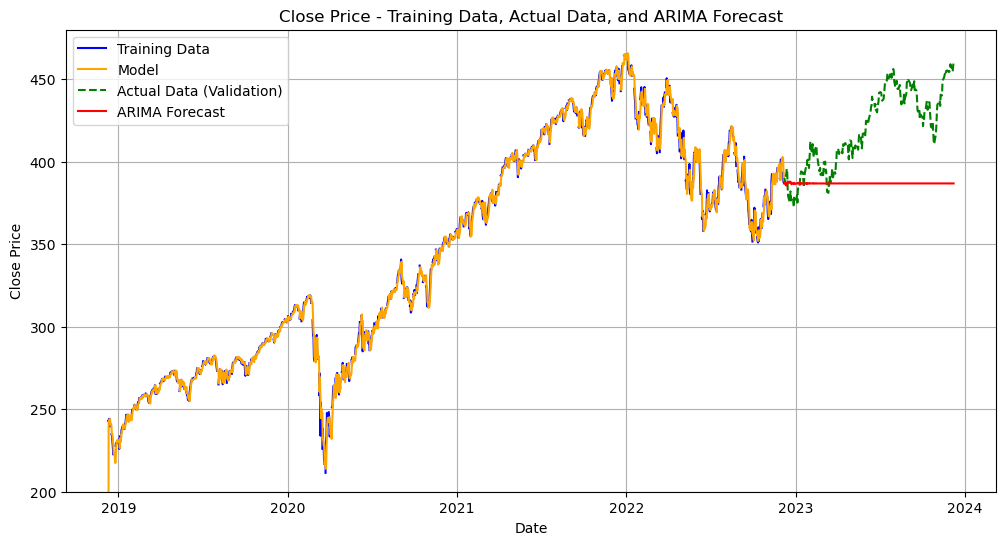

In [ ]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [ ]:
hist = aapl.history(period = '1y')

# Add columns for open-close difference, positive/negative, and high-low difference
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

Open        High         Low       Close  \
Date                                                                        
2022-12-09 00:00:00-05:00  388.819152  391.457610  387.056885  387.184875   
2022-12-12 00:00:00-05:00  388.001983  392.766998  387.312850  392.766998   
2022-12-13 00:00:00-05:00  403.862313  404.128118  392.885124  395.740173   
2022-12-14 00:00:00-05:00  395.385701  399.215427  390.167854  393.209961   
2022-12-15 00:00:00-05:00  388.189006  389.124295  381.878377  383.591400   

                              Volume  open_close  positive   high_low  
Date                                                                   
2022-12-09 00:00:00-05:00   81447700   -1.634277         0   4.400724  
2022-12-12 00:00:00-05:00   75405800    4.765015         1   5.454148  
2022-12-13 00:00:00-05:00  123782500   -8.122140         0  11.242993  
2022-12-14 00:00:00-05:00  108111300   -2.175740         0   9.047573  
2022-12-15 00:00:00-05:00  117705900   -4.597606         0   7.245918

In [ ]:
spy_desc = hist.copy()
spy_desc['Date'] = pd.to_datetime(spy_desc.index)
spy_desc.insert(0, 'day_of_week', spy_desc['Date'].dt.day_name())
spy_desc.head()

day_of_week        Open        High         Low  \
Date                                                                        
2022-12-09 00:00:00-05:00      Friday  388.819152  391.457610  387.056885   
2022-12-12 00:00:00-05:00      Monday  388.001983  392.766998  387.312850   
2022-12-13 00:00:00-05:00     Tuesday  403.862313  404.128118  392.885124   
2022-12-14 00:00:00-05:00   Wednesday  395.385701  399.215427  390.167854   
2022-12-15 00:00:00-05:00    Thursday  388.189006  389.124295  381.878377   

                                Close     Volume  open_close  positive  \
Date                                                                     
2022-12-09 00:00:00-05:00  387.184875   81447700   -1.634277         0   
2022-12-12 00:00:00-05:00  392.766998   75405800    4.765015         1   
2022-12-13 00:00:00-05:00  395.740173  123782500   -8.122140         0   
2022-12-14 00:00:00-05:00  393.209961  108111300   -2.175740         0   
2022-12-15 00:00:00-05:00  383.591400  117705900   -4.597606         0   

                            high_low                      Date  
Date                                                            
2022-12-09 00:00:00-05:00   4.400724 2022-12-09 00:00:00-05:00  
2022-12-12 00:00:00-05:00   5.454148 2022-12-12 00:00:00-05:00  
2022-12-13 00:00:00-05:00  11.242993 2022-12-13 00:00:00-05:00  
2022-12-14 00:00:00-05:00   9.047573 2022-12-14 00:00:00-05:00  
2022-12-15 00:00:00-05:00   7.245918 2022-12-15 00:00:00-05:00

In [ ]:
# From Deniega (2023) ADS 505 Final Project
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=spy_desc)
sns.set_style("whitegrid")
plt.title("SPY Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [ ]:
day_week_stats = spy_desc.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week     Friday     Monday   Thursday    Tuesday  Wednesday
count        52.000000  45.000000  51.000000  51.000000  52.000000
mean          0.723517   1.075894  -0.072333  -0.076668  -0.533182
std           3.112247   1.933707   3.719293   2.953370   2.884386
min          -5.024221  -3.412140  -8.090198  -8.122140  -7.437469
25%          -1.784516   0.039720  -2.288197  -1.717535  -2.474592
50%           0.850560   0.850006   0.239147   0.089996  -0.397810
75%           3.250672   2.220001   2.272510   1.449651   1.353934
max           7.570007   4.765015   9.187998   6.487128   5.528633

### S&P 500 appears to exhibit the least volatility on Mondays (using standard deviation) and the most volatility on Thursdays. This volatility in price should be used to determine typical risk/reward relative to other days of the week.

In [ ]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()

In [ ]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())

Open      High       Low     Close      Volume  \
Date                                                                            
2022-12-22 00:00:00-05:00 -0.415378  2.363773 -3.471455  0.692352  20242800.0   
2022-12-23 00:00:00-05:00  0.415388  0.820891  0.178032  2.343994 -14569900.0   
2022-12-27 00:00:00-05:00 -0.454984 -4.213289 -3.006679 -4.777039 -26529200.0   
2022-12-28 00:00:00-05:00 -1.701164 -2.789065  1.631869 -4.015472 -29209400.0   
2022-12-29 00:00:00-05:00 -0.019750  1.275867  1.038481  0.524200   7113600.0   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-22 00:00:00-05:00    1.107731       0.0  5.835228  -1.908784   
2022-12-23 00:00:00-05:00    1.928606       0.0  0.642859  -0.415378   
2022-12-27 00:00:00-05:00   -4.322054      -1.0 -1.206609   0.415388   
2022-12-28 00:00:00-05:00   -2.314309       0.0 -4.420933  -0.454984   
2022-12-29 00:00:00-05:00    0.543951       0.0  0.237386  -1.701164   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-22 00:00:00-05:00   0.820928  1.631904    2.927551  -41690600.0   
2022-12-23 00:00:00-05:00   2.363773 -3.471455    0.692352   20242800.0   
2022-12-27 00:00:00-05:00   0.820891  0.178032    2.343994  -14569900.0   
2022-12-28 00:00:00-05:00  -4.213289 -3.006679   -4.777039  -26529200.0   
2022-12-29 00:00:00-05:00  -2.789065  1.631869   -4.015472  -29209400.0   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-22 00:00:00-05:00         4.836335            1.0      -0.810975   
2022-12-23 00:00:00-05:00         1.107731            0.0       5.835228   
2022-12-27 00:00:00-05:00         1.928606            0.0       0.642859   
2022-12-28 00:00:00-05:00        -4.322054           -1.0      -1.206609   
2022-12-29 00:00:00-05:00        -2.314309            0.0      -4.420933   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-22 00:00:00-05:00 -13.121983 -11.090204 -8.176209   -7.228760   
2022-12-23 00:00:00-05:00  -1.908784   0.820928  1.631904    2.927551   
2022-12-27 00:00:00-05:00  -0.415378   2.363773 -3.471455    0.692352   
2022-12-28 00:00:00-05:00   0.415388   0.820891  0.178032    2.343994   
2022-12-29 00:00:00-05:00  -0.454984  -4.213289 -3.006679   -4.777039   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-22 00:00:00-05:00  -43278700.0         5.893223            1.0   
2022-12-23 00:00:00-05:00  -41690600.0         4.836335            1.0   
2022-12-27 00:00:00-05:00   20242800.0         1.107731            0.0   
2022-12-28 00:00:00-05:00  -14569900.0         1.928606            0.0   
2022-12-29 00:00:00-05:00  -26529200.0        -4.322054           -1.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-22 00:00:00-05:00      -2.913995      -16.125203      -19.608765   
2022-12-23 00:00:00-05:00      -0.810975      -13.121983      -11.090204   
2022-12-27 00:00:00-05:00       5.835228       -1.908784        0.820928   
2022-12-28 00:00:00-05:00       0.642859       -0.415378        2.363773   
2022-12-29 00:00:00-05:00      -1.206609        0.415388        0.820891   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-22 00:00:00-05:00     -16.040386       -17.361603       -28233200.0   
2022-12-23 00:00:00-05:00      -8.176209        -7.228760       -43278700.0   
2022-12-27 00:00:00

#### Reference: https://scikit-learn.org/

              precision    recall  f1-score   support

           0       0.50      0.71      0.59        14
           1       0.82      0.64      0.72        28

    accuracy                           0.67        42
   macro avg       0.66      0.68      0.65        42
weighted avg       0.71      0.67      0.68        42



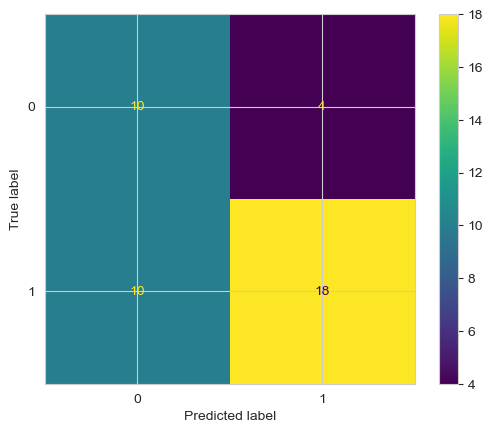

In [ ]:
## Change n to lag the data
#for n in range(1, 6):

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance
logreg_pred = logreg_model.predict(X_valid)
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

## Cross-sectional MLP (Neural Network) Model

Using cross-sectional since the dataframe that will be used already statically assigns the lagged values to its respective column. Shuffling across records does not dynamically change the values of the lagged columns.

### Make copy of historical data (differenced at lag=3)

In [ ]:
hist_diff = hist.copy()
lag = 3
hist_diff = hist_diff.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_diff.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_diff[lag_col_name] = hist_diff[col].shift(i)

hist_diff = hist_diff.dropna() # Remove missing values due to lags out of range
hist_diff.head()

Open      High       Low     Close      Volume  \
Date                                                                            
2022-12-22 00:00:00-05:00 -0.415378  2.363773 -3.471455  0.692352  20242800.0   
2022-12-23 00:00:00-05:00  0.415388  0.820891  0.178032  2.343994 -14569900.0   
2022-12-27 00:00:00-05:00 -0.454984 -4.213289 -3.006679 -4.777039 -26529200.0   
2022-12-28 00:00:00-05:00 -1.701164 -2.789065  1.631869 -4.015472 -29209400.0   
2022-12-29 00:00:00-05:00 -0.019750  1.275867  1.038481  0.524200   7113600.0   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-22 00:00:00-05:00    1.107731       0.0  5.835228  -1.908784   
2022-12-23 00:00:00-05:00    1.928606       0.0  0.642859  -0.415378   
2022-12-27 00:00:00-05:00   -4.322054      -1.0 -1.206609   0.415388   
2022-12-28 00:00:00-05:00   -2.314309       0.0 -4.420933  -0.454984   
2022-12-29 00:00:00-05:00    0.543951       0.0  0.237386  -1.701164   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-22 00:00:00-05:00   0.820928  1.631904    2.927551  -41690600.0   
2022-12-23 00:00:00-05:00   2.363773 -3.471455    0.692352   20242800.0   
2022-12-27 00:00:00-05:00   0.820891  0.178032    2.343994  -14569900.0   
2022-12-28 00:00:00-05:00  -4.213289 -3.006679   -4.777039  -26529200.0   
2022-12-29 00:00:00-05:00  -2.789065  1.631869   -4.015472  -29209400.0   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-22 00:00:00-05:00         4.836335            1.0      -0.810975   
2022-12-23 00:00:00-05:00         1.107731            0.0       5.835228   
2022-12-27 00:00:00-05:00         1.928606            0.0       0.642859   
2022-12-28 00:00:00-05:00        -4.322054           -1.0      -1.206609   
2022-12-29 00:00:00-05:00        -2.314309            0.0      -4.420933   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-22 00:00:00-05:00 -13.121983 -11.090204 -8.176209   -7.228760   
2022-12-23 00:00:00-05:00  -1.908784   0.820928  1.631904    2.927551   
2022-12-27 00:00:00-05:00  -0.415378   2.363773 -3.471455    0.692352   
2022-12-28 00:00:00-05:00   0.415388   0.820891  0.178032    2.343994   
2022-12-29 00:00:00-05:00  -0.454984  -4.213289 -3.006679   -4.777039   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-22 00:00:00-05:00  -43278700.0         5.893223            1.0   
2022-12-23 00:00:00-05:00  -41690600.0         4.836335            1.0   
2022-12-27 00:00:00-05:00   20242800.0         1.107731            0.0   
2022-12-28 00:00:00-05:00  -14569900.0         1.928606            0.0   
2022-12-29 00:00:00-05:00  -26529200.0        -4.322054           -1.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-22 00:00:00-05:00      -2.913995      -16.125203      -19.608765   
2022-12-23 00:00:00-05:00      -0.810975      -13.121983      -11.090204   
2022-12-27 00:00:00-05:00       5.835228       -1.908784        0.820928   
2022-12-28 00:00:00-05:00       0.642859       -0.415378        2.363773   
2022-12-29 00:00:00-05:00      -1.206609        0.415388        0.820891   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-22 00:00:00-05:00     -16.040386       -17.361603       -28233200.0   
2022-12-23 00:00:00-05:00      -8.176209        -7.228760       -43278700.0   
2022-12-27 00:00:00

### Preprocess dataframes for RobustScaler due to expected outlier stock price movements

In [ ]:
hist_diff_scale = RobustScaler().fit_transform(hist_diff)
hist_diff_scale = pd.DataFrame(hist_diff_scale, columns=hist_diff.columns, index=hist_diff.index)

# Reset positive column to correct for differencing on all columns
hist_diff_scale['positive'] = hist['positive']
hist_diff_scale.head()

Open      High       Low     Close    Volume  \
Date                                                                          
2022-12-22 00:00:00-05:00 -0.174718  0.199520 -0.650217 -0.069547  0.676510   
2022-12-23 00:00:00-05:00 -0.069559 -0.015303 -0.138827  0.142125 -0.375688   
2022-12-27 00:00:00-05:00 -0.179732 -0.716234 -0.585090 -0.770496 -0.737153   
2022-12-28 00:00:00-05:00 -0.337475 -0.517933  0.064894 -0.672895 -0.818161   
2022-12-29 00:00:00-05:00 -0.124639  0.048046 -0.018255 -0.091097  0.279686   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-22 00:00:00-05:00    0.200874         0  2.249394  -0.351329   
2022-12-23 00:00:00-05:00    0.356024         1  0.206173  -0.162291   
2022-12-27 00:00:00-05:00   -0.825391         0 -0.521602  -0.057132   
2022-12-28 00:00:00-05:00   -0.445914         0 -1.786453  -0.167305   
2022-12-29 00:00:00-05:00    0.094316         1  0.046617  -0.325048   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-22 00:00:00-05:00  -0.011263  0.064899    0.216913    -1.158293   
2022-12-23 00:00:00-05:00   0.203554 -0.650217   -0.069547     0.683609   
2022-12-27 00:00:00-05:00  -0.011269 -0.138827    0.142125    -0.351722   
2022-12-28 00:00:00-05:00  -0.712200 -0.585090   -0.770496    -0.707392   
2022-12-29 00:00:00-05:00  -0.513899  0.064894   -0.672895    -0.787101   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-22 00:00:00-05:00         0.893240            0.5      -0.354283   
2022-12-23 00:00:00-05:00         0.198131            0.0       2.261029   
2022-12-27 00:00:00-05:00         0.351164            0.0       0.217807   
2022-12-28 00:00:00-05:00        -0.814122           -0.5      -0.509967   
2022-12-29 00:00:00-05:00        -0.439826            0.0      -1.774819   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-22 00:00:00-05:00  -1.741303  -1.641886 -1.290783   -1.064183   
2022-12-23 00:00:00-05:00  -0.341674  -0.011076  0.073719    0.222234   
2022-12-27 00:00:00-05:00  -0.155268   0.200162 -0.636259   -0.060880   
2022-12-28 00:00:00-05:00  -0.051572  -0.011081 -0.128543    0.148320   
2022-12-29 00:00:00-05:00  -0.160211  -0.700334 -0.571599   -0.753644   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-22 00:00:00-05:00    -1.198209         1.043347            0.5   
2022-12-23 00:00:00-05:00    -1.151265         0.854795            0.5   
2022-12-27 00:00:00-05:00     0.679462         0.189604            0.0   
2022-12-28 00:00:00-05:00    -0.349588         0.336050            0.0   
2022-12-29 00:00:00-05:00    -0.703100        -0.779082           -0.5   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-22 00:00:00-05:00      -1.181831       -2.091286       -2.792262   
2022-12-23 00:00:00-05:00      -0.354283       -1.719131       -1.632566   
2022-12-27 00:00:00-05:00       2.261029       -0.329608       -0.011013   
2022-12-28 00:00:00-05:00       0.217807       -0.144547        0.199026   
2022-12-29 00:00:00-05:00      -0.509967       -0.041600       -0.011018   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-22 00:00:00-05:00      -2.357845        -2.347628         -0.753470   
2022-12-23 00:00:00-05:00      -1.276169        -1.064183         -1.198209   
2022-12-27 00:00:00-05:00       0

### Partition

In [ ]:
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_diff_scale.drop(['positive'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 63), (42, 63), (200,), (42,))

### Cross-sectional MLP (Neural Network) Model Fitting and Confusion Matrix

##### Gridsearch for the best set of parameters
#### To run and find best parameter takes some time

In [ ]:
# Inspired by Deniega (2023) ADS 505 Final Project
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16,
                           '(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)', '(7,7)', '(8,8)', '(9,9)', '(10,10)',
                           '(2,2,2)', '(3,3,3)', '(4,4,4)', '(5,5,5)', '(6,6,6)', '(7,7,7)', '(8,8,8)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnv

MLPClassifier(activation='tanh', hidden_layer_sizes=1, max_iter=2000,
              random_state=14, solver='sgd')

##### Fit parameters to MLP model

In [ ]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000, solver='sgd')
mlp_model.fit(X_train,y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000,
              solver='sgd')

##### Evaluate model with Confusion Matrix

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.96      0.96      0.96        28

    accuracy                           0.95        42
   macro avg       0.95      0.95      0.95        42
weighted avg       0.95      0.95      0.95        42



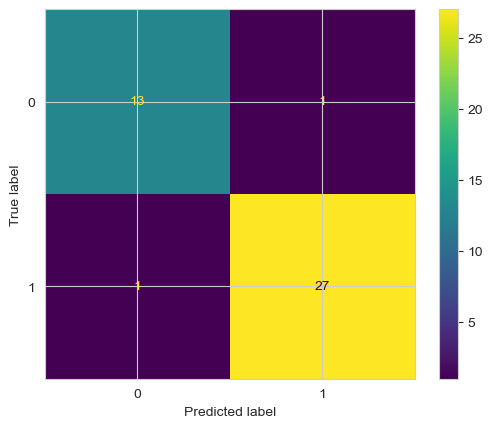

In [ ]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

## TEST: Try different parameters (hidden layers, solvers, etc.)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.96      0.93      0.95        28

    accuracy                           0.93        42
   macro avg       0.91      0.93      0.92        42
weighted avg       0.93      0.93      0.93        42



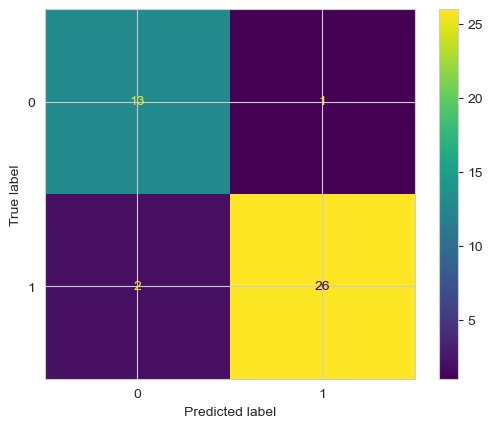

In [ ]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(3,2), max_iter=4000, solver='sgd',
                         random_state=14)
mlp_model.fit(X_train,y_train)
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

##### Hidden Layers (3,2) shows .95 accuracy!!!

### MLP Regressor

In [ ]:
mlpr = hist.copy()

y = hist['Close']
X = mlpr.drop(['Close'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 7), (51, 7), (200,), (51,))

### MLP Regressor Parameter search

In [ ]:
# Inspired by Deniega (2023) ADS 505 Final
# Finding best estimator will take some time
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16,
                           '(2,2)', '(3,2)', '(4,2)', '(5,2)', '(3,3)', '(3,4)', '(3,5)', '(4,3)', '(4,4)',
                           '(4,5)', '(5,4)', '(5,5)', '(2,2,2)', '(2,2,3)', '(2,3,2)', '(3,2,2)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPRegressor(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Run

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [ ]:
# Model and fitting
mlpr_model = MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')
mlpr_model.fit(X_train,y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [ ]:
mlpr_pred = mlpr_model.predict(X_valid)
mlpr_pred = pd.Series(mlpr_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlpr_pred.index)
#close_valid.shape, mlpr_pred.shape
ts_eval_metrics(y_valid, mlpr_pred)

Time Series Evaluation Metrics
MSE = 2.166272535623878
MAE = 1.118177116948089
RMSE = 1.471826258640563
MAPE = 0.002583230661705355
r2 = 0.9892767015507782



### High coefficent of determination and low error scores suggests the 8-neuron regressor may be overfitting the validation data. Further analysis required in future to iterate through lower-order neuron models to mitigate overfit risk.

## Amazon Closing Stock Price Analysis and Forecasting

In [3]:
# Download market data for Amazon:

amzn = yf.Ticker("AMZN")
#amzn.history_metadata

In [4]:
# Import Amazon stock dataset:

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

Open       High        Low      Close  \
Date                                                                    
2018-12-12 00:00:00-05:00  83.449997  85.249496  83.013496  83.177002   
2018-12-13 00:00:00-05:00  84.000000  84.606003  82.074997  82.918999   
2018-12-14 00:00:00-05:00  81.900002  82.128502  79.250000  79.595497   
2018-12-17 00:00:00-05:00  78.300003  78.806503  75.250504  76.045502   
2018-12-18 00:00:00-05:00  77.000000  78.377502  76.150497  77.573997   

                              Volume  Dividends  Stock Splits  
Date                                                           
2018-12-12 00:00:00-05:00  131960000        0.0           0.0  
2018-12-13 00:00:00-05:00  105426000        0.0           0.0  
2018-12-14 00:00:00-05:00  127344000        0.0           0.0  
2018-12-17 00:00:00-05:00  176596000        0.0           0.0  
2018-12-18 00:00:00-05:00  130460000        0.0           0.0

Open        High         Low       Close  \
Date                                                                        
2023-12-05 00:00:00-05:00  143.550003  148.570007  143.130005  146.880005   
2023-12-06 00:00:00-05:00  147.580002  147.850006  144.279999  144.520004   
2023-12-07 00:00:00-05:00  146.149994  147.919998  145.339996  146.880005   
2023-12-08 00:00:00-05:00  145.479996  147.839996  145.399994  147.419998   
2023-12-11 00:00:00-05:00  145.660004  146.190002  143.645004  145.889999   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-12-05 00:00:00-05:00  46822400        0.0           0.0  
2023-12-06 00:00:00-05:00  39679000        0.0           0.0  
2023-12-07 00:00:00-05:00  52352800        0.0           0.0  
2023-12-08 00:00:00-05:00  41858000        0.0           0.0  
2023-12-11 00:00:00-05:00  48264140        0.0           0.0

Open         High          Low        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean    126.894334   128.457127   125.226435   126.859390  7.702179e+07   
std      31.642177    31.926627    31.268731    31.557774  3.486990e+07   
min      67.300003    69.801498    65.349998    67.197998  1.762600e+07   
25%      95.099998    96.219999    94.053375    95.057997  5.373660e+07   
50%     126.020000   127.785000   124.285000   126.045002  6.666800e+07   
75%     158.346878   159.930752   156.224998   158.093746  9.043515e+07   
max     187.199997   188.654007   184.839493   186.570496  3.113460e+08   

       Dividends  Stock Splits  
count     1258.0   1258.000000  
mean         0.0      0.015898  
std          0.0      0.563884  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0     20.000000

In [5]:
# Plot initial Amazon stock time series at 5y time point:

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

### Partition train and validation datasets

In [6]:
# Partition train and validation datasets:

past_year0 = amzn_df.iloc[-252:] # 252 trading days per year
b_past_year = amzn_df.iloc[:-len(past_year0)]

amzn_dfa = amzn_df['Close'].asfreq('D')
amzn_dfa = amzn_dfa.ffill()

train = b_past_year['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.iloc[-len(past_year0):]
val_close = valid['Close'].asfreq('D')
val_close = val_close.ffill()

### Test of Stationarity Through Augmented Dickey–Fuller Method

In [ ]:
# Determine dataset stationarity:
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.413935
p-value: 0.575577
Critical Values:
{'1%': -3.434846127900848, '5%': -2.8635257411342616, '10%': -2.5678271914441395}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [ ]:
# Fit close stock price dataset to STL:

stl = STL(amzn_df['Close'], period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

In [ ]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_df)
plt.title('Amazon Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [ ]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

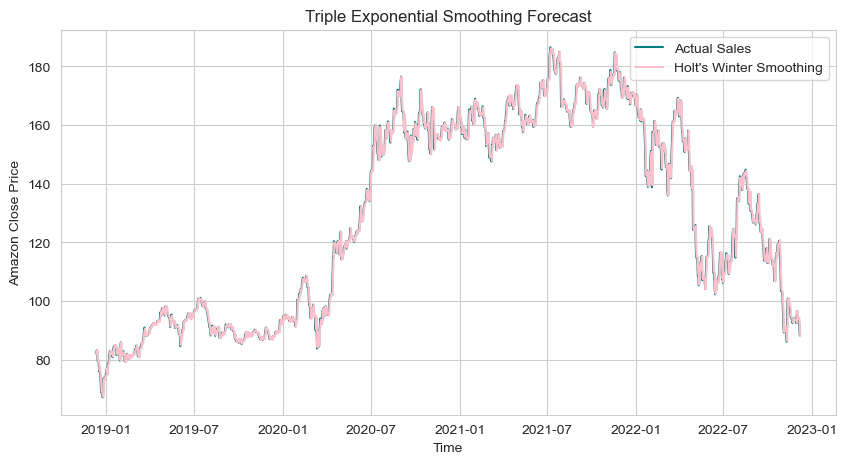

In [ ]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection Using STL Decomposition

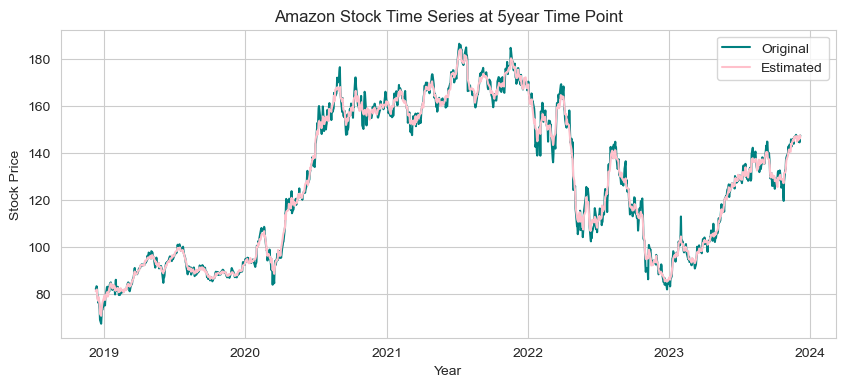

In [ ]:
# Plot original Amazon Close time series vs Forecasted time series:

estimated = trend + seasonal # from STL
plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'], label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Taking residuals and detecting anomaly at 3std. dev:

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

Text(0.5, 1.0, 'Amazon at 5year Time Point')

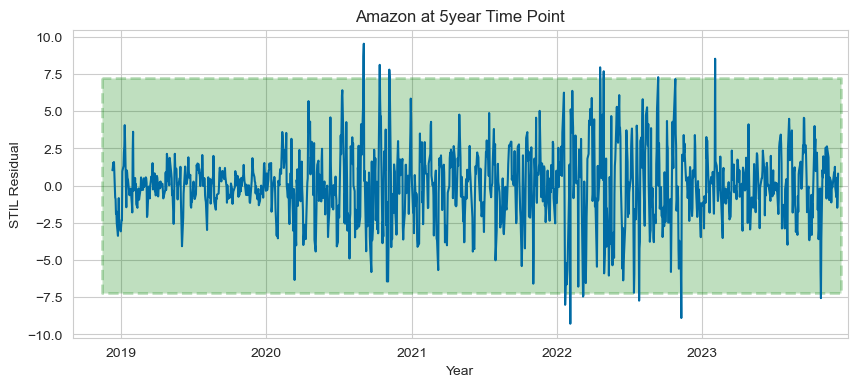

In [ ]:
# Plot residual threshold:

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('Amazon at 5year Time Point')

In [ ]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_df['Close'][(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

Text(0.5, 1.0, 'Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')

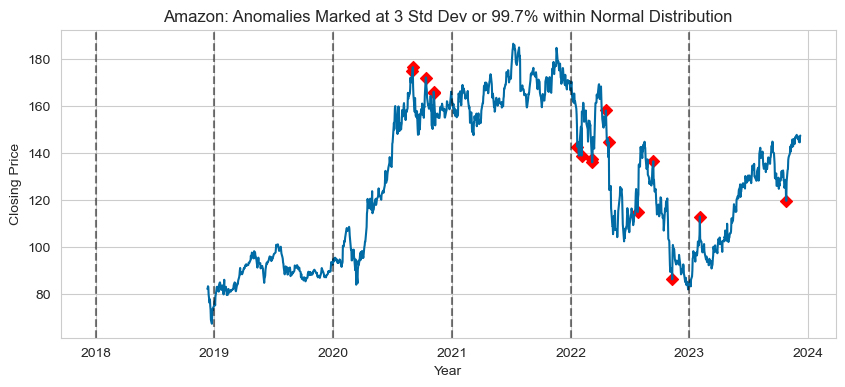

In [ ]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'])

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')


# Plot shows anomalies detected outside of +/- 3 Std Dev of normal distribution in red.
# Anomaly detection successful in detecting times market is most volitile.

In [ ]:
# Anomalies identified outside 3std dev of residuals:

anomalies.head()

Close
Date                                 
2020-09-01 00:00:00-04:00  174.955994
2020-09-02 00:00:00-04:00  176.572495
2020-10-12 00:00:00-04:00  172.146500
2020-11-05 00:00:00-05:00  166.100006
2020-11-06 00:00:00-05:00  165.568497

### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

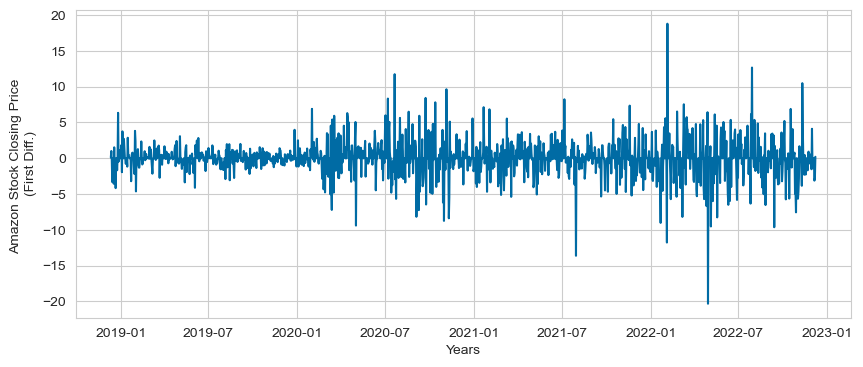

In [ ]:
# Removing trend by applying the first Difference:

diff_ts = amzn_train.diff().dropna()

# Plot first difference:

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [ ]:
# Determine dataset stationarity:
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -39.844311
p-value: 0.000000
Critical Values:
{'1%': -3.434846127900848, '5%': -2.8635257411342616, '10%': -2.5678271914441395}
Time series is stationary


### Selecting a Model

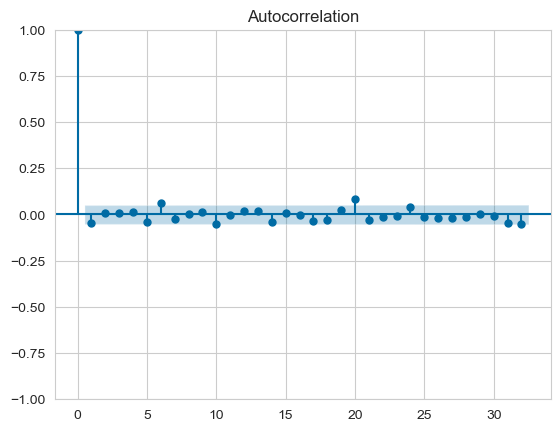

None

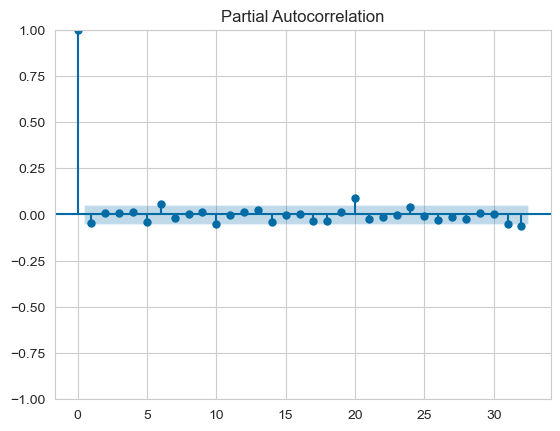

None

In [ ]:
# ACF suggest MA Lag 1, 6, 10, 20, 31, 32

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1, 6, 10, 20, 31, 32

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria:

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood
>
>($k$) = a number of parameters
>
>($n$) = a number of samples used for fitting


#### Auto-ARIMA Model

In [ ]:
# Auto ARIMA Model:

auto_arima_model = auto_arima(amzn_train, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

arima_pred0 = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6728.873, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6728.104, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6728.141, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6726.878, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6730.070, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.929 seconds


In [ ]:
# ARIMA Model and Forecast at ARIMA(2,1,2):

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m = sm.tsa.ARIMA(amzn_train, order=(2,1,2)).fit()
print(arima_m.summary())

arima_pred1 = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3355.525
Date:                Sun, 10 Dec 2023   AIC                           6721.049
Time:                        15:41:32   BIC                           6747.473
Sample:                    12-10-2018   HQIC                          6730.907
                         - 12-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5613      0.012    -47.232      0.000      -0.585      -0.538
ar.L2         -0.9785      0.012    -84.184      0.000      -1.001      -0.956
ma.L1          0.5415      0.012     45.588      0.0

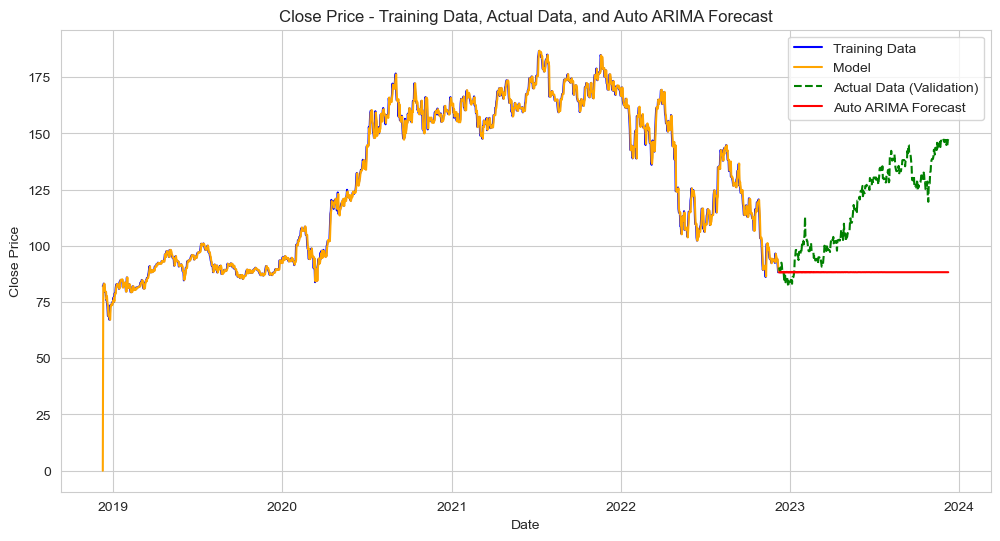

In [ ]:
# Plot Auto ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred1, label='Auto ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and Auto ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot shows best performing ARIMA parameter at (2, 1, 2) values of p,d,q.
# Although, the auto forecast did very poorly in predicting the validation dataset.

#### ARIMA Model

In [ ]:
# AR lag optimization:

ar_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ar_order0 in enumerate(ar_orders0):
    ar_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(ar_order0,1,1),trend='n')
    ar_model_fit0 = ar_model0.fit()
    fitted_model_dict[ar_order0] = ar_model_fit0

for ar_order0 in ar_orders0:
    print('AIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].aic))
    print('BIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].bic))
    print('\n')

AIC for AR(1): 6728.075399778217
BIC for AR(1): 6743.929862515923


AIC for AR(6): 6730.013934614347
BIC for AR(6): 6772.292501914896


AIC for AR(10): 6733.658153278002
BIC for AR(10): 6797.076004228825


AIC for AR(20): 6733.723372013398
BIC for AR(20): 6849.9894320899075


AIC for AR(31): 6743.868427767137
BIC for AR(31): 6918.267517881901


AIC for AR(32): 6740.83613052737
BIC for AR(32): 6920.520041554702




##### Result:

AR order 1 has the lowest AIC and BIC scores.

In [ ]:
# MA lag optimization:

ma_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ma_order0 in enumerate(ma_orders0):
    ma_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(1,1,ma_order0),trend='n')
    ma_model_fit0 = ma_model0.fit()
    fitted_model_dict[ma_order0] = ma_model_fit0

for ma_order0 in ma_orders0:
    print('AIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].aic))
    print('BIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].bic))
    print('\n')

AIC for AR(1): 6728.075399778217
BIC for AR(1): 6743.929862515923


AIC for AR(6): 6729.527848792389
BIC for AR(6): 6771.806416092938


AIC for AR(10): 6734.261947411695
BIC for AR(10): 6797.679798362517


AIC for AR(20): 6731.635139639482
BIC for AR(20): 6847.901199715991


AIC for AR(31): 6743.176881724676
BIC for AR(31): 6917.575971839439


AIC for AR(32): 6742.3765098140875
BIC for AR(32): 6922.06042084142




##### Result:

MA order 1 has the lowest AIC and BIC scores.

In [ ]:
# ARIMA Model and Forecast at ARIMA(1,1,1):

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m0 = sm.tsa.ARIMA(amzn_train, order=(1,1,1)).fit()
print(arima_m0.summary())

arima_pred2 = arima_m0.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3361.038
Date:                Sun, 10 Dec 2023   AIC                           6728.075
Time:                        15:42:18   BIC                           6743.930
Sample:                    12-10-2018   HQIC                          6733.990
                         - 12-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1457      0.585     -0.249      0.803      -1.293       1.002
ma.L1          0.1023      0.585      0.175      0.861      -1.044       1.249
sigma2         5.8862      0.105     55.893      0.0

In [ ]:
# Statistical Metrics:

print('AIC = %s' %(arima_m0.aic))
print('BIC = %s' %(arima_m0.bic))
arima0_metrics = ts_eval_metrics(val_close, arima_pred2)

AIC = 6728.075399778217
BIC = 6743.929862515923
Time Series Evaluation Metrics
MSE = 1196.104960676091
MAE = 29.24667468189848
RMSE = 34.584750406444904
MAPE = 0.22931725380692158
r2 = -2.2639286757493404



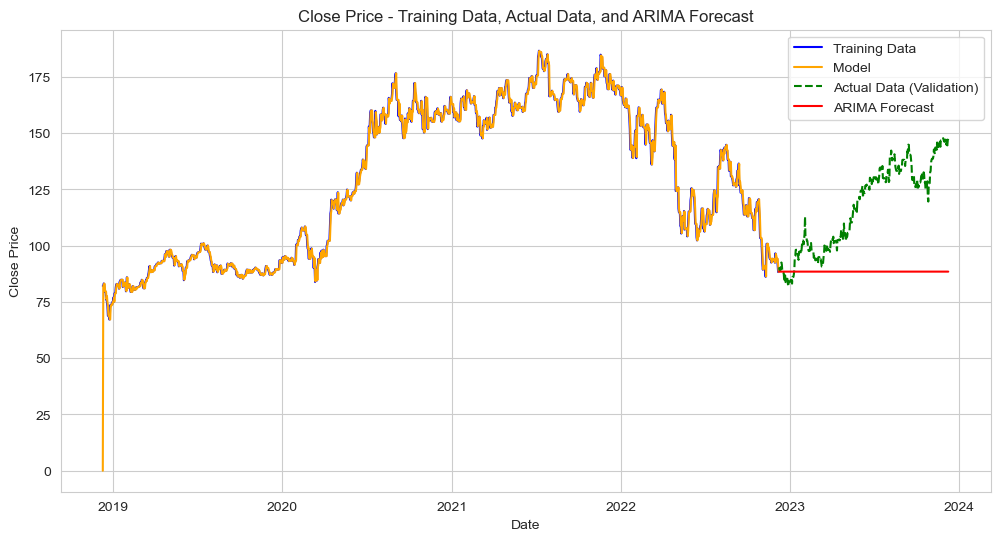

In [ ]:
# Plot ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m0.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred2, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Same with auto-ARIMA, ARIMA with (1,1,1) parameters selected through metric scores performance did very poorly.
# Manual selection of ARIMA parameters did not predict closing prices well compared to the validation dataset.

#### AES Model

In [ ]:
# Define AES parameters for optimization:

aes_param_trend0 = ['add', 'mul', None]
aes_param_seasonal0 = ['add', 'mul', None] # set to mul by default
aes_param_initial_method0 = [None, 'estimated', 'heuristic', 'legacy-heuristic']


fitted_model_dict0 = {}

In [ ]:
# Trend parameter optimization:

for i in aes_param_trend0:
    aes_model2 = ExponentialSmoothing(amzn_train,
                                     trend=i,
                                     damped_trend=False, # Error message: Can only dampen the trend component
                                     seasonal= 'mul',
                                     seasonal_periods= 252,
                                     initialization_method='heuristic'
                                    )
    aes_model2 = aes_model2.fit(
                             )

    print('Results for Trend %s' % (i))
    print('AIC = %s' %(aes_model2.aic))
    print('BIC = %s' %(aes_model2.bic))
    aes_pred2 = aes_model2.forecast(steps=len(val_close))
    aes_eval_metrics2 = ts_eval_metrics(val_close, aes_pred2)

Results for Trend add
AIC = 2934.5563517005053
BIC = 4287.646028122338
Time Series Evaluation Metrics
MSE = 790.0455836585023
MAE = 23.514820544314144
RMSE = 28.107749530307515
MAPE = 0.1838630277426549
r2 = -1.1558747103553042

Results for Trend mul
AIC = 2935.5855122337844
BIC = 4288.675188655618
Time Series Evaluation Metrics
MSE = 767.3052331850399
MAE = 23.190623536892414
RMSE = 27.700274965874254
MAPE = 0.18138724971014386
r2 = -1.0938208902917457

Results for Trend None
AIC = 2930.2010934804093
BIC = 4272.719756805197
Time Series Evaluation Metrics
MSE = 1236.8252307940666
MAE = 29.72744058007214
RMSE = 35.168526139064554
MAPE = 0.23314950374747948
r2 = -2.3750460623432343



##### Result

No trend parameter has the lowest AIC and BIC scores.

In [ ]:
# Initialization method optimization:

for i in aes_param_initial_method0:
    aes_model3 = ExponentialSmoothing(amzn_train,
                                     trend= None,
                                     seasonal= 'mul',
                                     seasonal_periods= 252,
                                     initialization_method=i
                                    )
    aes_model3 = aes_model3.fit(
                             )

    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model3.aic))
    print('BIC = %s' %(aes_model3.bic))
    aes_pred3 = aes_model3.forecast(steps=len(val_close))
    aes_eval_metrics3 = ts_eval_metrics(val_close, aes_pred3)

Results for Initialization Method None
AIC = 3610.313263924425
BIC = 4952.831927249213
Time Series Evaluation Metrics
MSE = 1630.8044861963228
MAE = 36.122851192022445
RMSE = 40.383220354453194
MAPE = 0.2917843034913069
r2 = -3.4501358175357373

Results for Initialization Method estimated
AIC = 2770.9803738597275
BIC = 4113.499037184515
Time Series Evaluation Metrics
MSE = 1446.4260826442885
MAE = 32.84979098719123
RMSE = 38.03190874311055
MAPE = 0.2600964587616569
r2 = -2.9470044216069002

Results for Initialization Method heuristic
AIC = 2930.2010934804093
BIC = 4272.719756805197
Time Series Evaluation Metrics
MSE = 1236.8252307940666
MAE = 29.72744058007214
RMSE = 35.168526139064554
MAPE = 0.23314950374747948
r2 = -2.3750460623432343

Results for Initialization Method legacy-heuristic
AIC = 3610.313263924425
BIC = 4952.831927249213
Time Series Evaluation Metrics
MSE = 1630.8044861963228
MAE = 36.122851192022445
RMSE = 40.383220354453194
MAPE = 0.2917843034913069
r2 = -3.450135817535

##### Result

For initialization method, heuristic and estimated methods performed the best.

In [ ]:
# Final AES Model on train dataset:

aes_modelf = ExponentialSmoothing(amzn_train,
                                 trend= None,
                                 seasonal= 'mul', # set by default, add is poor performer visually
                                 seasonal_periods= 252, #252 trading days per year forecast
                                 initialization_method='heuristic')

aes_modelf = aes_modelf.fit(smoothing_level=.5,
                              smoothing_trend=.5)


aes_predf = aes_modelf.forecast(steps=len(val_close))
aes_eval_metricsf = ts_eval_metrics(val_close, aes_predf)

print('AIC = %s' %(aes_modelf.aic))
print('BIC = %s' %(aes_modelf.bic))

Time Series Evaluation Metrics
MSE = 1166.1011283779612
MAE = 28.614833480756666
RMSE = 34.14822291683655
MAPE = 0.2237256340214873
r2 = -2.182054281912795

AIC = 3281.5178422667677
BIC = 4624.036505591555


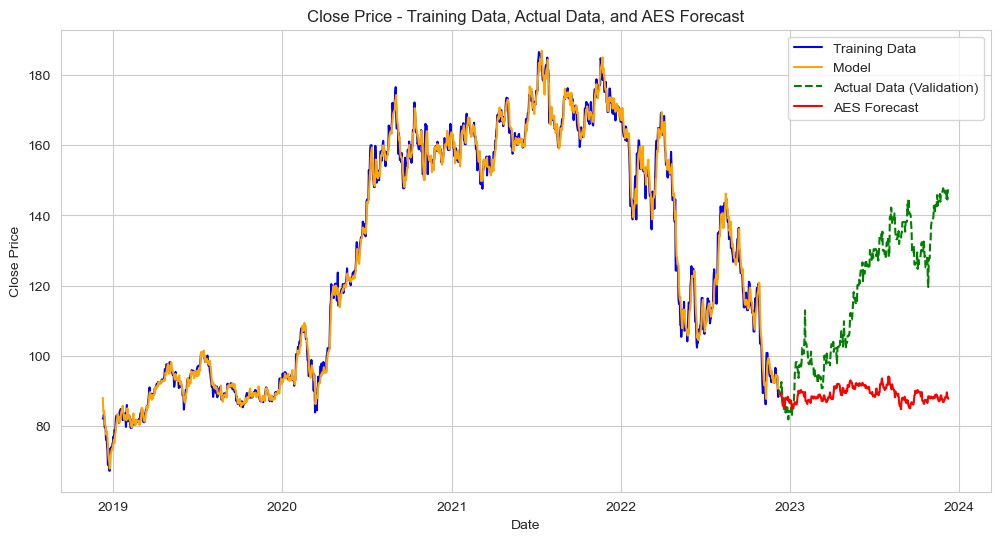

In [ ]:
# Plot AES Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(aes_modelf.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, aes_predf, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()


# AES forecasting model performed better than ARIMA model.
# But compared to the validation dataset, AES did poorly overall.

#### Logistic Regression

In [ ]:
# Pull 1 year Amazon history log:

amzn_1 = yf.Ticker("AMZN")
hist0 = amzn_1.history(period = '1y')


# Create new predictors and outcome variables:

hist0['open_close'] = hist0['Close'] - hist0['Open']
hist0['positive'] = np.where(hist0['open_close'] > 0, 1, 0)

hist0['high_low'] = hist0['High'] - hist0['Low']
hist0 = hist0.drop(['Dividends', 'Stock Splits'], axis=1)

hist0.head()

Open       High        Low      Close  \
Date                                                                    
2022-12-09 00:00:00-05:00  88.900002  90.300003  88.629997  89.089996   
2022-12-12 00:00:00-05:00  89.209999  90.580002  87.870003  90.550003   
2022-12-13 00:00:00-05:00  95.230003  96.250000  90.519997  92.489998   
2022-12-14 00:00:00-05:00  92.500000  93.459999  89.870003  91.580002   
2022-12-15 00:00:00-05:00  89.889999  89.970001  87.470001  88.449997   

                              Volume  open_close  positive  high_low  
Date                                                                  
2022-12-09 00:00:00-05:00   67398500    0.189995         1  1.670006  
2022-12-12 00:00:00-05:00   61999800    1.340004         1  2.709999  
2022-12-13 00:00:00-05:00  100212000   -2.740005         0  5.730003  
2022-12-14 00:00:00-05:00   70298000   -0.919998         0  3.589996  
2022-12-15 00:00:00-05:00   84802900   -1.440002         0  2.500000

In [ ]:
amzn_desc = hist0.copy()
amzn_desc['Date'] = pd.to_datetime(amzn_desc.index)
amzn_desc.insert(0, 'day_of_week', amzn_desc['Date'].dt.day_name())
amzn_desc.head()

day_of_week       Open       High        Low  \
Date                                                                     
2022-12-09 00:00:00-05:00      Friday  88.900002  90.300003  88.629997   
2022-12-12 00:00:00-05:00      Monday  89.209999  90.580002  87.870003   
2022-12-13 00:00:00-05:00     Tuesday  95.230003  96.250000  90.519997   
2022-12-14 00:00:00-05:00   Wednesday  92.500000  93.459999  89.870003   
2022-12-15 00:00:00-05:00    Thursday  89.889999  89.970001  87.470001   

                               Close     Volume  open_close  positive  \
Date                                                                    
2022-12-09 00:00:00-05:00  89.089996   67398500    0.189995         1   
2022-12-12 00:00:00-05:00  90.550003   61999800    1.340004         1   
2022-12-13 00:00:00-05:00  92.489998  100212000   -2.740005         0   
2022-12-14 00:00:00-05:00  91.580002   70298000   -0.919998         0   
2022-12-15 00:00:00-05:00  88.449997   84802900   -1.440002         0   

                           high_low                      Date  
Date                                                           
2022-12-09 00:00:00-05:00  1.670006 2022-12-09 00:00:00-05:00  
2022-12-12 00:00:00-05:00  2.709999 2022-12-12 00:00:00-05:00  
2022-12-13 00:00:00-05:00  5.730003 2022-12-13 00:00:00-05:00  
2022-12-14 00:00:00-05:00  3.589996 2022-12-14 00:00:00-05:00  
2022-12-15 00:00:00-05:00  2.500000 2022-12-15 00:00:00-05:00

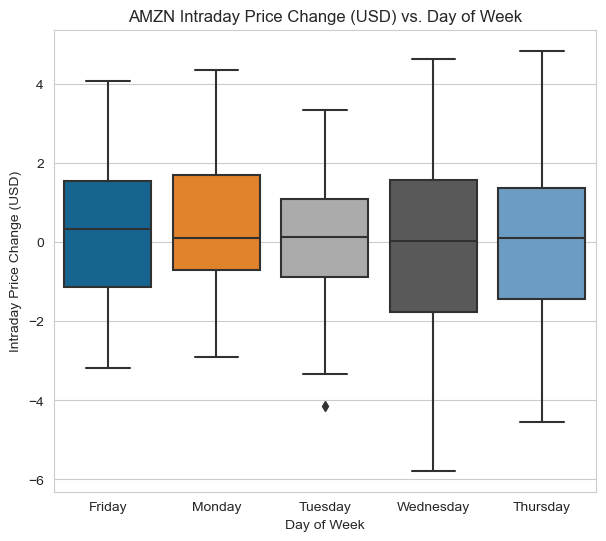

In [ ]:
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=amzn_desc)
sns.set_style("whitegrid")
plt.title("AMZN Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [ ]:
day_week_stats = amzn_desc.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week     Friday     Monday   Thursday    Tuesday  Wednesday
count        52.000000  45.000000  51.000000  51.000000  52.000000
mean          0.368846   0.314889   0.076274   0.011568  -0.109807
std           1.884142   1.607839   2.068960   1.625446   2.260142
min          -3.190002  -2.899994  -4.559998  -4.139992  -5.779999
25%          -1.144995  -0.700005  -1.435001  -0.875004  -1.754997
50%           0.330002   0.110001   0.110001   0.119995   0.019997
75%           1.555002   1.690002   1.380001   1.085003   1.579996
max           4.070000   4.350006   4.839996   3.330002   4.620003

### Wednesdays appear to have the most volatile price movements at $2.26 standard deviation with Monday and Tuesday showing the lowest volatility.

### Recommendation: Buy/Sell Amazon.com stock early in the week to minimize likelihood of Wednesday volatility.

In [ ]:
hist0_lag = hist0.copy()

lag = 3

hist0_lag = hist0_lag.diff(periods=lag)

for i in range(1, lag+1):
    for col in hist0_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist0_lag[lag_col_name] = hist0_lag[col].shift(i)

hist0_lag = hist0_lag.dropna()

In [ ]:
pd.set_option('display.max_columns', 70)
display(hist0_lag.head())

Open      High       Low     Close      Volume  \
Date                                                                            
2022-12-22 00:00:00-05:00 -1.990005 -1.949997 -2.260002 -1.129997  -2100200.0   
2022-12-23 00:00:00-05:00 -2.080002 -0.830002 -1.400002  0.059998 -16914600.0   
2022-12-27 00:00:00-05:00 -1.209999 -1.880005 -2.209999 -3.729996  -1983200.0   
2022-12-28 00:00:00-05:00 -2.719994 -2.199997 -0.559998 -1.970001 -23202700.0   
2022-12-29 00:00:00-05:00 -0.379997 -1.229996 -0.379997 -1.070000  -2437800.0   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-22 00:00:00-05:00    0.860008       0.0  0.310005  -2.089996   
2022-12-23 00:00:00-05:00    2.139999       1.0  0.570000  -1.990005   
2022-12-27 00:00:00-05:00   -2.519997      -1.0  0.329994  -2.080002   
2022-12-28 00:00:00-05:00    0.749992       0.0 -1.639999  -1.209999   
2022-12-29 00:00:00-05:00   -0.690002       0.0 -0.849998  -2.719994   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-22 00:00:00-05:00  -2.119995 -1.520004   -1.090004  -86876900.0   
2022-12-23 00:00:00-05:00  -1.949997 -2.260002   -1.129997   -2100200.0   
2022-12-27 00:00:00-05:00  -0.830002 -1.400002    0.059998  -16914600.0   
2022-12-28 00:00:00-05:00  -1.880005 -2.209999   -3.729996   -1983200.0   
2022-12-29 00:00:00-05:00  -2.199997 -0.559998   -1.970001  -23202700.0   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-22 00:00:00-05:00         0.999992            1.0      -0.599991   
2022-12-23 00:00:00-05:00         0.860008            0.0       0.310005   
2022-12-27 00:00:00-05:00         2.139999            1.0       0.570000   
2022-12-28 00:00:00-05:00        -2.519997           -1.0       0.329994   
2022-12-29 00:00:00-05:00         0.749992            0.0      -1.639999   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-22 00:00:00-05:00  -4.559998  -3.360001 -3.139999   -3.259995   
2022-12-23 00:00:00-05:00  -2.089996  -2.119995 -1.520004   -1.090004   
2022-12-27 00:00:00-05:00  -1.990005  -1.949997 -2.260002   -1.129997   
2022-12-28 00:00:00-05:00  -2.080002  -0.830002 -1.400002    0.059998   
2022-12-29 00:00:00-05:00  -1.209999  -1.880005 -2.209999   -3.729996   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-22 00:00:00-05:00  -10454600.0         1.300003            0.0   
2022-12-23 00:00:00-05:00  -86876900.0         0.999992            1.0   
2022-12-27 00:00:00-05:00   -2100200.0         0.860008            0.0   
2022-12-28 00:00:00-05:00  -16914600.0         2.139999            1.0   
2022-12-29 00:00:00-05:00   -1983200.0        -2.519997           -1.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-22 00:00:00-05:00      -0.220001       -4.989998       -5.830002   
2022-12-23 00:00:00-05:00      -0.599991       -4.559998       -3.360001   
2022-12-27 00:00:00-05:00       0.310005       -2.089996       -2.119995   
2022-12-28 00:00:00-05:00       0.570000       -1.990005       -1.949997   
2022-12-29 00:00:00-05:00       0.329994       -2.080002       -0.830002   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-22 00:00:00-05:00      -5.360001        -6.660004        13233500.0   
2022-12-23 00:00:00-05:00      -3.139999        -3.259995       -10454600.0   
2022-12-27 00:00:00

              precision    recall  f1-score   support

           0       0.33      0.40      0.36        15
           1       0.62      0.56      0.59        27

    accuracy                           0.50        42
   macro avg       0.48      0.48      0.48        42
weighted avg       0.52      0.50      0.51        42



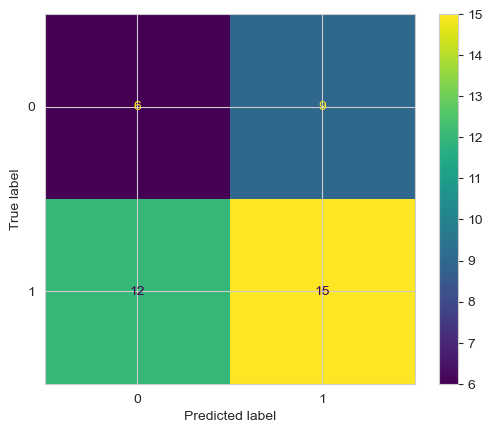

In [ ]:
# Data partition for logistic regression:

y1 = hist0['positive']
X1 = hist0_lag.drop(['positive'], axis=1)
y1 = y1.reindex(X1.index)

end_train_index1 = 200
X1_train = X1.iloc[:end_train_index1]
X1_valid = X1.iloc[end_train_index1:]

y1_train = y1.iloc[:end_train_index1]
y1_valid = y1.iloc[end_train_index1:]


# Logistic regression model and fitting:

logreg_model1 = LogisticRegression()
logreg_model1.fit(X1_train,y1_train)


# Model Performance

logreg_pred1 = logreg_model1.predict(X1_valid)
logreg_pred1 = pd.Series(logreg_pred1, index=X1_valid.index)
y1_valid = y1_valid.reindex(logreg_pred1.index)

cm1 = confusion_matrix(y1_valid, logreg_pred1, labels=logreg_model1.classes_)
cmd1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=logreg_model1.classes_)
cmd1.plot()

print(classification_report(y1_valid, logreg_pred1))

#### Recurrent Neutal Network: Simple RNN and Dense  

In [ ]:
#!pip install tensorflow

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [8]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(amzn_dfa.values.reshape(-1, 1))


In [9]:
# Prepare the data for training
def create_sequences(amzn_dfa, seq_length):
    sequences = []
    targets = []
    for i in range(len(amzn_dfa) - seq_length):
        seq = amzn_dfa[i:i+seq_length]
        target = amzn_dfa[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10  # You can adjust this parameter based on your needs
X, y = create_sequences(ts_scaled, sequence_length)


In [10]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1, activation='linear'))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_percentage_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

Epoch 1/50
91/91 [==============================] - 3s 6ms/step - loss: 188405.4062
Epoch 2/50
91/91 [==============================] - 1s 6ms/step - loss: 31196.3008
Epoch 3/50
91/91 [==============================] - 1s 6ms/step - loss: 54626.7891
Epoch 4/50
91/91 [==============================] - 1s 7ms/step - loss: 42137.1406
Epoch 5/50
91/91 [==============================] - 0s 5ms/step - loss: 18491.6250
Epoch 6/50
91/91 [==============================] - 1s 6ms/step - loss: 14289.9561
Epoch 7/50
91/91 [==============================] - 1s 7ms/step - loss: 19090.9473
Epoch 8/50
91/91 [==============================] - 0s 5ms/step - loss: 12656.7246
Epoch 9/50
91/91 [==============================] - 1s 7ms/step - loss: 17343.7637
Epoch 10/50
91/91 [==============================] - 1s 6ms/step - loss: 7912.1006
Epoch 11/50
91/91 [==============================] - 1s 6ms/step - loss: 8630.6855
Epoch 12/50
91/91 [==============================] - 1s 6ms/step - loss: 41219.6992
Ep

In [12]:
# Inverse transform the predictions and actual values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


# Calculate and print the metrics
aes_eval_metricsf = ts_eval_metrics(y_test_inv, y_pred_inv)

Time Series Evaluation Metrics
MSE = 8.247485776856102
MAE = 2.011667251586914
RMSE = 2.8718436198470316
MAPE = 0.018265820721018313
r2 = 0.9773957060097056



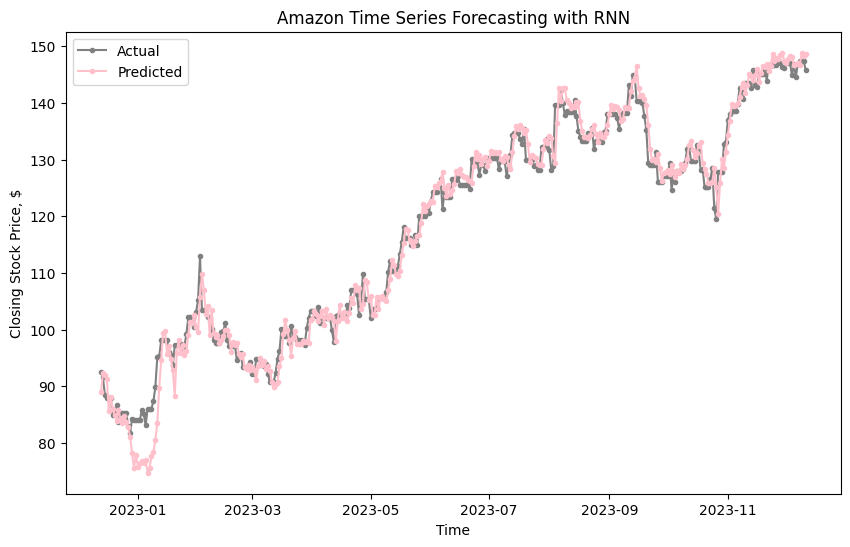

In [14]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(amzn_dfa.index[train_size + sequence_length:], y_test_inv, label='Actual', marker='.', color = 'gray')
plt.plot(amzn_dfa.index[train_size + sequence_length:], y_pred_inv, label='Predicted', marker='.', color = 'pink')
plt.title('Amazon Time Series Forecasting with RNN')
plt.xlabel('Time')
plt.ylabel('Closing Stock Price, $')
plt.legend()
plt.show()

# RNN forecast model did really well in predicting the test dataset as shown below.

###### References:

Brownlee J. (2020, April 12). A gentle introduction to exponential smoothing for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

Brownlee, J. (2020, August 28). How to grid search triple exponential smoothing for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

OpenAI. (2023). ChatGPT. ). http://www.openai.com/product/chatgpt

Chaudhari, S. (2021, February 11). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

ritvikmath. (2020, August 27). Seasonal-trend decomposition using LOESS. Github. https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb

Shmueli, G. (2016). ARIMA models [Video]. YouTube. https://youtu.be/0xHf-SJ9Z9U?feature=shared

statsmodels. (2023, May 05). statsmodels.tsa.holtwinters.ExponentialSmoothing. statsmodels.   https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#

statsmodels. (2023, May 05). Time series analysis. statsmodels. https://www.statsmodels.org/stable/tsa.html

statsmodels. (2023, December 08). Graphics. statsmodels. https://www.statsmodels.org/devel/graphics.html#time-series-plots

TensorFlow. (2023, September 27). tf.keras.Sequential. TensorFlow.
    https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

University of San Diego. (n.d.). Lab 1.2: Model selection. University of San Diego.   https://sandiego.instructure.com/courses/847/pages/lab-1-dot-2-model-selection?module_item_id=226903
    